In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive
drive.mount('/content/drive')
import json
import torchvision.ops
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from torchvision.ops import box_convert

import matplotlib.pyplot as plt
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [4]:
#Common Objects in Context
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [5]:
class UI_Element_Detection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "annotations_train.json"))  # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    # to load annotations for a given image ID.
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        # print(f"Loading index: {index}")  # Basic logging
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # copies the annotations to avoid modifying the original data.
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        category_id_to_index = {cat_id: idx for idx, (cat_id, cat_info) in enumerate(categories.items())}

        targ = {}  # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([category_id_to_index[t['category_id']] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ  # scale images

    def __len__(self):
        return len(self.ids)

In [6]:
dataset_path = "/content/drive/My Drive/MASC_UI_dataset/MASC_UI/MASC_UI/Login/"

In [7]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "annotations_train.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


{1: {'id': 1, 'name': 'Element'},
 2: {'id': 2, 'name': 'ImageView'},
 3: {'id': 3, 'name': 'TextView'},
 4: {'id': 4, 'name': 'Button'},
 5: {'id': 5, 'name': 'CheckBox'},
 6: {'id': 6, 'name': 'Input'}}

In [8]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Element', 'ImageView', 'TextView', 'Button', 'CheckBox', 'Input']

In [9]:
train_dataset = UI_Element_Detection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [10]:
val_dataset = UI_Element_Detection(root=dataset_path, split="val", transforms=get_transforms(False))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


File Name: 42511.jpg
Bounding Box 0: tensor([   0.0000,   39.3750, 1200.0000,  118.1250]), Category ID: 0, Category Name: Element
Bounding Box 1: tensor([393.3333, 160.3125, 451.6667, 194.0625]), Category ID: 1, Category Name: ImageView
Bounding Box 2: tensor([475.0000, 161.7188, 806.6667, 192.6562]), Category ID: 2, Category Name: TextView
Bounding Box 3: tensor([  46.6667,  249.3750, 1153.3334,  306.5625]), Category ID: 2, Category Name: TextView
Bounding Box 4: tensor([  46.6667,  345.9375, 1153.3334,  403.1250]), Category ID: 5, Category Name: Input
Bounding Box 5: tensor([ 46.6667, 416.2500, 423.3333, 491.7188]), Category ID: 0, Category Name: Element
Bounding Box 6: tensor([  46.6667,  491.7188, 1153.3334,  557.3438]), Category ID: 3, Category Name: Button
Bounding Box 7: tensor([ 845.8333,  583.5938, 1153.3334,  640.7812]), Category ID: 2, Category Name: TextView
Bounding Box 8: tensor([  46.6667,  680.1562, 1153.3334,  745.7812]), Category ID: 3, Category Name: Button


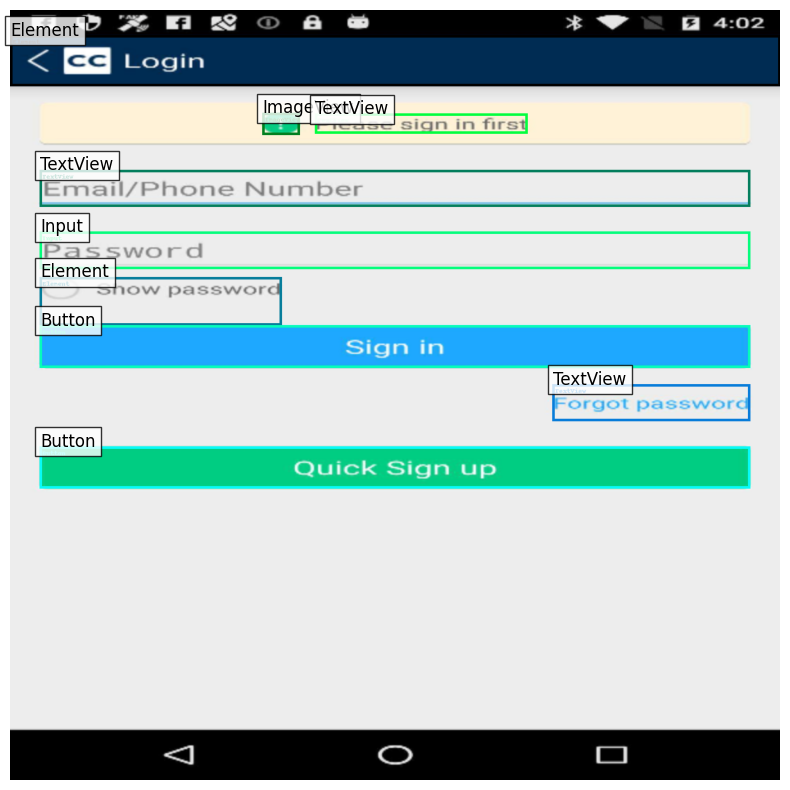

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Add method to get file name
def get_file_name(coco, image_id):
    return coco.loadImgs(image_id)[0]['file_name']

# Let's view a sample
sample_index = 333 # Sample index to view
sample = train_dataset[sample_index]
img_tensor = sample[0] * 255
img_int = img_tensor.to(torch.uint8)

# Get the file name
image_id = sample[1]['image_id'][0].item()  # Take the first image_id from the tensor
file_name = get_file_name(train_dataset.coco, image_id)

# Resize image for a larger display
# This will not increase the actual quality but will make the image larger on the screen
# Replace 'new_width' and 'new_height' with desired dimensions
new_width, new_height = img_tensor.shape[2] * 2, img_tensor.shape[1] * 2  # For example, doubling the size
img_resized = F.resize(img_int, [new_height, new_width])

# Convert boxes to the resized scale
boxes_resized = sample[1]['boxes'] * torch.tensor([2, 2, 2, 2], dtype=torch.float32)

# Draw bounding boxes on the resized image
img_with_boxes = draw_bounding_boxes(
    img_resized, boxes_resized, [classes[i] for i in sample[1]['labels']], width=4
)

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))  # You can adjust the display size by changing the figsize
plt.imshow(img_with_boxes.permute(1, 2, 0))

# Increase font size for bounding box labels
for i, label in enumerate(sample[1]['labels']):
    box = boxes_resized[i]
    category_id = label.item()
    category_name = classes[category_id]
    plt.text(box[0], box[1], f"{category_name}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.axis('off')  # Hide the axes

# Print the file name
print(f"File Name: {file_name}")

# Print the category_id for each bounding box
for i, label in enumerate(sample[1]['labels']):
    box = boxes_resized[i]
    category_id = label.item()
    print(f"Bounding Box {i}: {box}, Category ID: {category_id}, Category Name: {classes[category_id]}")

plt.show()

In [12]:
# MobileNet V3 is a type of convolutional neural network used to extract features from the input image
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# ROI (Region of Interest) is used to ensure compatibility when customizing the model's prediction head for a specific number of classes.
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
# DataLoader class provided by PyTorch that provides an iterable over the data.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [15]:
val_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [16]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
# passes the list of images and targets to the model to ensure it runs without errors.
output = model(images, targets)

In [17]:
device = torch.device("cuda") # use GPU to train

In [18]:
model = model.to(device)

In [19]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [20]:
import sys

In [21]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

    return all_losses, all_losses_dict


In [25]:
# import torch
# import time
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pycocotools.coco import COCO
# import os
# from tqdm import tqdm
# import math

# num_epochs = 3


# # Start the timer for total training time
# total_start_time = time.time()

# for epoch in range(num_epochs):
#     # Start the timer for the epoch
#     epoch_start_time = time.time()

#     losses, losses_dict = train_one_epoch(model, optimizer, train_loader, device, epoch)

#     # Store the epoch loss values
#     epoch_losses.append(np.mean(losses))
#     epoch_losses_dict.append(losses_dict.mean())

# # End the timer for total training time
# total_end_time = time.time()
# total_duration = total_end_time - total_start_time
# print(f"Total training time: {total_duration:.2f} seconds")


In [26]:
# # Convert epoch_losses_dict to a DataFrame for easier plotting
# epoch_losses_df = pd.DataFrame(epoch_losses_dict)

# # Plot the overall loss
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_epochs), epoch_losses, label='Total Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.legend()
# plt.show()

# # Plot the individual components of the loss
# plt.figure(figsize=(10, 6))
# plt.plot(range(num_epochs), epoch_losses_df['loss_classifier'], label='Loss Classifier')
# plt.plot(range(num_epochs), epoch_losses_df['loss_box_reg'], label='Loss Box Reg')
# plt.plot(range(num_epochs), epoch_losses_df['loss_rpn_box_reg'], label='Loss RPN Box Reg')
# plt.plot(range(num_epochs), epoch_losses_df['loss_objectness'], label='Loss Objectness')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Individual Loss Components Over Epochs')
# plt.legend()
# plt.show()


CUDA is available. Using GPU.


100%|██████████| 156/156 [02:01<00:00,  1.28it/s]

Epoch 0, lr: 0.005000, loss: 1.204872, loss_classifier: 0.381636, loss_box: 0.370721, loss_rpn_box: 0.249929, loss_object: 0.202586


No predictions for class 4.
No true positives for class 4.
Epoch 0 - Train mAP@0.50: 0.5186581619092864
Class 1 - Precision: 0.6086660373990179, Recall: 0.3779004239726816, AP: 0.41059813029758296
Class 2 - Precision: 0.904304405790634, Recall: 0.33876881079620624, AP: 0.5455941937328275
Class 3 - Precision: 0.9801583115087419, Recall: 0.4290425367675903, AP: 0.7619607511358324
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9966064546611316, Recall: 0.45443814117806913, AP: 0.8751377343801888
No predictions for class 4.
No true positives for class 4.
Epoch 0 - Validation mAP@0.50: 0.5186657721797197
Class 1 - Precision: 0.6142611732455148, Recall: 0.3828320996066528, AP: 0.41560974339651524
Class 2 - Precision: 0.9018989628345065, Recall: 0.3372529905978253, AP: 0.5398661432474551
Class 3 - Precision: 0.9802931862676376, Recall: 0.4286872648997645, AP: 0.7591882576415788
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9977060910263958, Recal

100%|██████████| 156/156 [00:34<00:00,  4.46it/s]

Epoch 1, lr: 0.005000, loss: 0.875640, loss_classifier: 0.279962, loss_box: 0.275952, loss_rpn_box: 0.190269, loss_object: 0.129457


No predictions for class 4.
No true positives for class 4.
Epoch 1 - Train mAP@0.50: 0.5582614083688316
Class 1 - Precision: 0.855554155055696, Recall: 0.28061377666860565, AP: 0.428664759074585
Class 2 - Precision: 0.8035828940549934, Recall: 0.4904546054130542, AP: 0.6581077253736692
Class 3 - Precision: 0.987008649260853, Recall: 0.40535253011392985, AP: 0.7645563970150124
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9037641219091342, Recall: 0.6487425539529583, AP: 0.9399781603808917
No predictions for class 4.
No true positives for class 4.
Epoch 1 - Validation mAP@0.50: 0.556681890358614
Class 1 - Precision: 0.8607344286115192, Recall: 0.28257824107921986, AP: 0.43723442637255494
Class 2 - Precision: 0.7916367858364288, Recall: 0.4868832957807847, AP: 0.649934885757685
Class 3 - Precision: 0.9846887600731313, Recall: 0.39976863009736824, AP: 0.755523736363332
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.8973874432522809, Recall: 0

100%|██████████| 156/156 [00:34<00:00,  4.47it/s]

Epoch 2, lr: 0.005000, loss: 0.809752, loss_classifier: 0.261430, loss_box: 0.252631, loss_rpn_box: 0.175441, loss_object: 0.120250


No predictions for class 4.
No true positives for class 4.
Epoch 2 - Train mAP@0.50: 0.5774155877949573
Class 1 - Precision: 0.673550183512277, Recall: 0.4583404067840456, AP: 0.5488310523307371
Class 2 - Precision: 0.8798012088624216, Recall: 0.3733706593258167, AP: 0.5830729685296038
Class 3 - Precision: 0.9737170354623618, Recall: 0.4597357762506949, AP: 0.8001231561439826
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9708738440500427, Recall: 0.5770216587449812, AP: 0.955050761970463
No predictions for class 4.
No true positives for class 4.
Epoch 2 - Validation mAP@0.50: 0.5713703378655217
Class 1 - Precision: 0.6813939665618687, Recall: 0.4552529505027549, AP: 0.5461771915799574
Class 2 - Precision: 0.8616466848892701, Recall: 0.36604578169118257, AP: 0.5692114258785248
Class 3 - Precision: 0.9724539129313268, Recall: 0.45854452702734266, AP: 0.7928183489189577
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9694826610482636, Recall: 

100%|██████████| 156/156 [00:33<00:00,  4.64it/s]

Epoch 3, lr: 0.005000, loss: 0.775528, loss_classifier: 0.253796, loss_box: 0.240261, loss_rpn_box: 0.165101, loss_object: 0.116371


No predictions for class 4.
No true positives for class 4.
Epoch 3 - Train mAP@0.50: 0.5485078866542714
Class 1 - Precision: 0.9145910161700828, Recall: 0.30444430717180887, AP: 0.49392786185482596
Class 2 - Precision: 0.9116783706755422, Recall: 0.38557379473528536, AP: 0.6220291255001199
Class 3 - Precision: 0.9828191626616491, Recall: 0.4153617223948699, AP: 0.7516517061828808
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9971744814110417, Recall: 0.4571577979877069, AP: 0.8749307397335304
No predictions for class 4.
No true positives for class 4.
Epoch 3 - Validation mAP@0.50: 0.5527045671556376
Class 1 - Precision: 0.9034206440112886, Recall: 0.2971482113254691, AP: 0.4833351417323234
Class 2 - Precision: 0.9067946146338003, Recall: 0.3899551287347701, AP: 0.6198297029251634
Class 3 - Precision: 0.9823210598693346, Recall: 0.42247446729087845, AP: 0.769413943255477
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9962640394451037, Recal

100%|██████████| 156/156 [00:34<00:00,  4.49it/s]

Epoch 4, lr: 0.005000, loss: 0.747471, loss_classifier: 0.243458, loss_box: 0.229199, loss_rpn_box: 0.161967, loss_object: 0.112847


No predictions for class 4.
No true positives for class 4.
Epoch 4 - Train mAP@0.50: 0.6011926703737517
Class 1 - Precision: 0.7783729557028934, Recall: 0.45154367659660266, AP: 0.6069023418087216
Class 2 - Precision: 0.8781388991713751, Recall: 0.3888319731771773, AP: 0.6073530020177209
Class 3 - Precision: 0.9729546827191817, Recall: 0.48262479665543295, AP: 0.833213977908095
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9697730112560107, Recall: 0.5828311219238458, AP: 0.958494030134221
No predictions for class 4.
No true positives for class 4.
Epoch 4 - Validation mAP@0.50: 0.5955278806800132
Class 1 - Precision: 0.7687129776531462, Recall: 0.4417258028929288, AP: 0.5859641482233854
Class 2 - Precision: 0.8809116940351034, Recall: 0.3905661589872116, AP: 0.6140380220644043
Class 3 - Precision: 0.9722583057341373, Recall: 0.4751764497730917, AP: 0.8209403029316165
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9706465441638107, Recall: 

100%|██████████| 156/156 [00:34<00:00,  4.51it/s]

Epoch 5, lr: 0.005000, loss: 0.727799, loss_classifier: 0.237845, loss_box: 0.223877, loss_rpn_box: 0.158339, loss_object: 0.107737


No predictions for class 4.
No true positives for class 4.
Epoch 5 - Train mAP@0.50: 0.6029445929182906
Class 1 - Precision: 0.9088566761802624, Recall: 0.31449074137717714, AP: 0.5280701179552884
Class 2 - Precision: 0.845081124521553, Recall: 0.4587207018462747, AP: 0.6767165465879896
Class 3 - Precision: 0.9635442671146632, Recall: 0.5097141970359258, AP: 0.8593678799203082
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9636539705324704, Recall: 0.5884433663278137, AP: 0.9505684201278661
No predictions for class 4.
No true positives for class 4.
Epoch 5 - Validation mAP@0.50: 0.6016902279044467
Class 1 - Precision: 0.9043939223627716, Recall: 0.31164032356714844, AP: 0.5171495310627862
Class 2 - Precision: 0.8447036162826629, Recall: 0.4573878356483016, AP: 0.6761751569513794
Class 3 - Precision: 0.9625176284447812, Recall: 0.5113055832964407, AP: 0.861692396583069
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9609710744762937, Recall: 

100%|██████████| 156/156 [00:34<00:00,  4.58it/s]

Epoch 6, lr: 0.005000, loss: 0.710286, loss_classifier: 0.234452, loss_box: 0.215645, loss_rpn_box: 0.153865, loss_object: 0.106324


No predictions for class 4.
No true positives for class 4.
Epoch 6 - Train mAP@0.50: 0.6047377322582823
Class 1 - Precision: 0.9059632603304087, Recall: 0.3668360987769728, AP: 0.5854461211343952
Class 2 - Precision: 0.9061207344656876, Recall: 0.3656763590391909, AP: 0.5934050714756185
Class 3 - Precision: 0.9485849277868198, Recall: 0.5479590887871755, AP: 0.8891997595665495
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9745148013400445, Recall: 0.5707920263903066, AP: 0.9556377091148485
No predictions for class 4.
No true positives for class 4.
Epoch 6 - Validation mAP@0.50: 0.6076437567279674
Class 1 - Precision: 0.9049869749292895, Recall: 0.37417159096551905, AP: 0.6001009951596767
Class 2 - Precision: 0.9090536308321329, Recall: 0.36057455402128297, AP: 0.5872326594502839
Class 3 - Precision: 0.9478513564816375, Recall: 0.5513180153750616, AP: 0.8928515258752312
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9762656459278403, Recall

100%|██████████| 156/156 [00:34<00:00,  4.54it/s]

Epoch 7, lr: 0.005000, loss: 0.707148, loss_classifier: 0.231576, loss_box: 0.215213, loss_rpn_box: 0.155400, loss_object: 0.104958


No predictions for class 4.
No true positives for class 4.
Epoch 7 - Train mAP@0.50: 0.6092041832099866
Class 1 - Precision: 0.9069450787916107, Recall: 0.3721995072200652, AP: 0.593696009200645
Class 2 - Precision: 0.828447123402869, Recall: 0.4170263061801052, AP: 0.6185250030017871
Class 3 - Precision: 0.944245024323848, Recall: 0.5328604078695001, AP: 0.8713799434692996
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.8987319652235443, Recall: 0.6695894998999617, AP: 0.9624199603782011
No predictions for class 4.
No true positives for class 4.
Epoch 7 - Validation mAP@0.50: 0.6097681314157523
Class 1 - Precision: 0.9065187603464675, Recall: 0.37304180921695357, AP: 0.5951411482922109
Class 2 - Precision: 0.8266313604970708, Recall: 0.4169242890712239, AP: 0.6183336332942477
Class 3 - Precision: 0.9466088305657815, Recall: 0.5303888106593111, AP: 0.869638177723105
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9003982984312796, Recall: 0.6

100%|██████████| 156/156 [00:35<00:00,  4.43it/s]

Epoch 8, lr: 0.005000, loss: 0.677648, loss_classifier: 0.220742, loss_box: 0.210425, loss_rpn_box: 0.145933, loss_object: 0.100548


Epoch 8 - Train mAP@0.50: 0.614777445480892
Class 1 - Precision: 0.8980303642564428, Recall: 0.3346815007432567, AP: 0.5490908967120498
Class 2 - Precision: 0.885107887046047, Recall: 0.42507520487622896, AP: 0.6631568374130079
Class 3 - Precision: 0.9432899613175085, Recall: 0.5570818154678506, AP: 0.8945925422310174
Class 4 - Precision: 1.0, Recall: 0.014705882352941176, AP: 0.014705882352941176
Class 5 - Precision: 0.923505989171405, Recall: 0.6386548062171106, AP: 0.9523410686954439
Epoch 8 - Validation mAP@0.50: 0.6163984592491436
Class 1 - Precision: 0.8969705506094926, Recall: 0.3458564416526007, AP: 0.5526173958254528
Class 2 - Precision: 0.8929066830313594, Recall: 0.4267029475933545, AP: 0.6671811387185089
Class 3 - Precision: 0.9436711783619839, Recall: 0.5606721061063299, AP: 0.8982947077050525
Class 4 - Precision: 1.0, Recall: 0.014705882352941176, AP: 0.014705882352941176
Class 5 - Precision: 0.9232714402001994, Recall: 0.6353765164895192, AP: 0.9491931716437629
Epoch 8 c

100%|██████████| 156/156 [00:35<00:00,  4.41it/s]

Epoch 9, lr: 0.005000, loss: 0.666342, loss_classifier: 0.222282, loss_box: 0.204065, loss_rpn_box: 0.144858, loss_object: 0.095137


No predictions for class 4.
No true positives for class 4.
Epoch 9 - Train mAP@0.50: 0.576573426350367
Class 1 - Precision: 0.9502847492504728, Recall: 0.3070761213844953, AP: 0.5258471138345091
Class 2 - Precision: 0.9272432992031503, Recall: 0.3726461074238031, AP: 0.6222629134496922
Class 3 - Precision: 0.9921231123285194, Recall: 0.3986786292348049, AP: 0.7699313952662825
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.9685602156451735, Recall: 0.5870870527278564, AP: 0.9648257092013517
No predictions for class 4.
No true positives for class 4.
Epoch 9 - Validation mAP@0.50: 0.5785845143831996
Class 1 - Precision: 0.9398622216866858, Recall: 0.3123103388290778, AP: 0.5313323936767238
Class 2 - Precision: 0.9207149212511967, Recall: 0.3858261013611139, AP: 0.628647158355921
Class 3 - Precision: 0.9911219063581115, Recall: 0.3978958531004075, AP: 0.7690763702071718
Class 4 - Precision: nan, Recall: nan, AP: 0.0
Class 5 - Precision: 0.965827629410031, Recall: 0.5

100%|██████████| 156/156 [00:36<00:00,  4.23it/s]

Epoch 10, lr: 0.005000, loss: 0.663292, loss_classifier: 0.219602, loss_box: 0.205415, loss_rpn_box: 0.142470, loss_object: 0.095805


Epoch 10 - Train mAP@0.50: 0.6737771946906299
Class 1 - Precision: 0.8442721768507554, Recall: 0.5044609843092077, AP: 0.710074307759126
Class 2 - Precision: 0.8643948030201708, Recall: 0.4726584490624817, AP: 0.7130050679230857
Class 3 - Precision: 0.9540441678059252, Recall: 0.547406490383927, AP: 0.9054977138543321
Class 4 - Precision: 0.6434540207267481, Recall: 0.049465240641711226, AP: 0.06488731856378915
Class 5 - Precision: 0.9433987457279083, Recall: 0.6321822329625463, AP: 0.9754215653528171
Epoch 10 - Validation mAP@0.50: 0.6684603162292103
Class 1 - Precision: 0.8383074394474398, Recall: 0.5161208493243128, AP: 0.7126473409084533
Class 2 - Precision: 0.8583112566288984, Recall: 0.46910667397838574, AP: 0.7016240936401507
Class 3 - Precision: 0.9594200783059268, Recall: 0.5388691769402394, AP: 0.9038655243539084
Class 4 - Precision: 0.5344797178130511, Recall: 0.042483660130718956, AP: 0.05106209150326797
Class 5 - Precision: 0.9410514659937523, Recall: 0.6330783920102073, A

100%|██████████| 156/156 [00:34<00:00,  4.50it/s]

Epoch 11, lr: 0.005000, loss: 0.644025, loss_classifier: 0.211335, loss_box: 0.201532, loss_rpn_box: 0.139742, loss_object: 0.091415


Epoch 11 - Train mAP@0.50: 0.6474619402960513
Class 1 - Precision: 0.9221829404334252, Recall: 0.42659884216483807, AP: 0.6838123474558164
Class 2 - Precision: 0.9185953449697861, Recall: 0.37722898878695343, AP: 0.6277404954612765
Class 3 - Precision: 0.9651749841186723, Recall: 0.540507936694446, AP: 0.9059251989603422
Class 4 - Precision: 1.0, Recall: 0.02941176470588235, AP: 0.04411764705882353
Class 5 - Precision: 0.9554208329504104, Recall: 0.6173909070845004, AP: 0.975714012543998
Epoch 11 - Validation mAP@0.50: 0.6400769280981413
Class 1 - Precision: 0.9155083981101863, Recall: 0.42444733464069556, AP: 0.6735946389644739
Class 2 - Precision: 0.9214372246389652, Recall: 0.36656773451427627, AP: 0.6221503370877002
Class 3 - Precision: 0.9656542157144251, Recall: 0.5358988461721087, AP: 0.9010116492409568
Class 4 - Precision: 1.0, Recall: 0.022058823529411763, AP: 0.029411764705882353
Class 5 - Precision: 0.9582167113738433, Recall: 0.6106647311912329, AP: 0.9742162504916936
Epoch

100%|██████████| 156/156 [00:37<00:00,  4.20it/s]

Epoch 12, lr: 0.005000, loss: 0.640021, loss_classifier: 0.208974, loss_box: 0.199592, loss_rpn_box: 0.138059, loss_object: 0.093396


Epoch 12 - Train mAP@0.50: 0.6653472900385179
Class 1 - Precision: 0.9160483218008241, Recall: 0.43222336697575015, AP: 0.685227263246108
Class 2 - Precision: 0.9028947674291368, Recall: 0.43833083497802894, AP: 0.6984372917608487
Class 3 - Precision: 0.9604568749894299, Recall: 0.5325953660313868, AP: 0.8969609986574321
Class 4 - Precision: 0.44749676249676246, Recall: 0.056862745098039215, AP: 0.08137254901960783
Class 5 - Precision: 0.9651972339500664, Recall: 0.5851728082036238, AP: 0.9647383475085924
Epoch 12 - Validation mAP@0.50: 0.6694277766044439
Class 1 - Precision: 0.9230686135359161, Recall: 0.43089818287877046, AP: 0.6926554551564761
Class 2 - Precision: 0.9058992978754111, Recall: 0.4310367976591726, AP: 0.6916792062503575
Class 3 - Precision: 0.9639359282698926, Recall: 0.5337756303127276, AP: 0.8969517895655689
Class 4 - Precision: 0.7089789839789838, Recall: 0.07647058823529411, AP: 0.10441176470588234
Class 5 - Precision: 0.9674444027496439, Recall: 0.5802491698772216

100%|██████████| 156/156 [00:33<00:00,  4.71it/s]

Epoch 13, lr: 0.005000, loss: 0.620516, loss_classifier: 0.204217, loss_box: 0.192911, loss_rpn_box: 0.135677, loss_object: 0.087711


Epoch 13 - Train mAP@0.50: 0.6511900047337906
Class 1 - Precision: 0.9097425105570414, Recall: 0.446561256470754, AP: 0.7033264806061774
Class 2 - Precision: 0.9011539329764832, Recall: 0.44339163573549484, AP: 0.7151178704956915
Class 3 - Precision: 0.990966334081391, Recall: 0.4089145389781657, AP: 0.7954158935000992
Class 4 - Precision: 0.8663690476190476, Recall: 0.05330882352941176, AP: 0.08088235294117647
Class 5 - Precision: 0.9834580215148655, Recall: 0.5473644680828282, AP: 0.9612074261258083
Epoch 13 - Validation mAP@0.50: 0.6508723975424205
Class 1 - Precision: 0.904205740040124, Recall: 0.4357716469666785, AP: 0.6838017595366714
Class 2 - Precision: 0.898124253491344, Recall: 0.4506092912210947, AP: 0.7224332849662036
Class 3 - Precision: 0.9912160570286733, Recall: 0.40780258814100373, AP: 0.7943350159108011
Class 4 - Precision: 0.7694885361552027, Recall: 0.053921568627450976, AP: 0.08660130718954248
Class 5 - Precision: 0.9830744226326928, Recall: 0.5562640262537638, AP:

100%|██████████| 156/156 [00:35<00:00,  4.41it/s]

Epoch 14, lr: 0.005000, loss: 0.618516, loss_classifier: 0.202631, loss_box: 0.194808, loss_rpn_box: 0.133268, loss_object: 0.087809


Epoch 14 - Train mAP@0.50: 0.6900559349489532
Class 1 - Precision: 0.8964835906132015, Recall: 0.4679600471293916, AP: 0.7112944318223807
Class 2 - Precision: 0.8755232138211066, Recall: 0.5067847269130115, AP: 0.7488384570768924
Class 3 - Precision: 0.9495492976831376, Recall: 0.5595840626003078, AP: 0.9094724009277034
Class 4 - Precision: 0.5827670715317521, Recall: 0.09497549019607843, AP: 0.10948879551820728
Class 5 - Precision: 0.9527403511281288, Recall: 0.6139662643144538, AP: 0.9711855893995822
Epoch 14 - Validation mAP@0.50: 0.7018177673535838
Class 1 - Precision: 0.9014821922849213, Recall: 0.4762960827798792, AP: 0.7248331751222228
Class 2 - Precision: 0.879155556833323, Recall: 0.49758798395560194, AP: 0.7463247757228094
Class 3 - Precision: 0.9492286365109224, Recall: 0.560129275092766, AP: 0.9146388624188626
Class 4 - Precision: 0.7753573380953411, Recall: 0.1088235294117647, AP: 0.14844744716068245
Class 5 - Precision: 0.9558920301957368, Recall: 0.6130385216070471, AP: 

100%|██████████| 156/156 [00:34<00:00,  4.46it/s]

Epoch 15, lr: 0.005000, loss: 0.607817, loss_classifier: 0.195755, loss_box: 0.193218, loss_rpn_box: 0.132252, loss_object: 0.086592


Epoch 15 - Train mAP@0.50: 0.6729428739357
Class 1 - Precision: 0.9481102317806224, Recall: 0.40983151781916366, AP: 0.6904380382779829
Class 2 - Precision: 0.910084416019821, Recall: 0.4493896777269462, AP: 0.728351558732774
Class 3 - Precision: 0.9937656442713501, Recall: 0.44290431365059585, AP: 0.8381523432976216
Class 4 - Precision: 0.82008436008436, Recall: 0.09019607843137253, AP: 0.1400667959491489
Class 5 - Precision: 0.9786860559112188, Recall: 0.5680297880789287, AP: 0.9677056334209724
Epoch 15 - Validation mAP@0.50: 0.6656648719612663
Class 1 - Precision: 0.9490640892557178, Recall: 0.41312339331619535, AP: 0.6991677675910231
Class 2 - Precision: 0.9117002044235232, Recall: 0.4566162125430194, AP: 0.7374539210886728
Class 3 - Precision: 0.9926192931165586, Recall: 0.4515664328437898, AP: 0.8452260330980139
Class 4 - Precision: 0.5610441410441409, Recall: 0.06372549019607844, AP: 0.07773109243697479
Class 5 - Precision: 0.9784323766794344, Recall: 0.5694450508349269, AP: 0.9

100%|██████████| 156/156 [00:38<00:00,  4.09it/s]

Epoch 16, lr: 0.005000, loss: 0.582341, loss_classifier: 0.186491, loss_box: 0.185756, loss_rpn_box: 0.128635, loss_object: 0.081458


Epoch 16 - Train mAP@0.50: 0.6950331853922331
Class 1 - Precision: 0.9391863771186115, Recall: 0.4417455722243429, AP: 0.7281102499794793
Class 2 - Precision: 0.8842214116272877, Recall: 0.50610866736001, AP: 0.7808880823204908
Class 3 - Precision: 0.961663886185064, Recall: 0.5515622496700412, AP: 0.9171254334596223
Class 4 - Precision: 1.0, Recall: 0.044117647058823525, AP: 0.07352941176470588
Class 5 - Precision: 0.9476433439997732, Recall: 0.622199907842874, AP: 0.9755127494368673
Epoch 16 - Validation mAP@0.50: 0.6910886690404299
Class 1 - Precision: 0.9402555349913093, Recall: 0.44534334727892866, AP: 0.732635520169548
Class 2 - Precision: 0.8746986623883894, Recall: 0.5073627271792672, AP: 0.7659964022327918
Class 3 - Precision: 0.9617031357564215, Recall: 0.5595838924914835, AP: 0.9249344999008084
Class 4 - Precision: 1.0, Recall: 0.036764705882352935, AP: 0.058823529411764705
Class 5 - Precision: 0.9454716217637292, Recall: 0.6248158298248837, AP: 0.9730533934872366
Epoch 16 c

100%|██████████| 156/156 [00:34<00:00,  4.55it/s]

Epoch 17, lr: 0.005000, loss: 0.585121, loss_classifier: 0.185929, loss_box: 0.189863, loss_rpn_box: 0.126385, loss_object: 0.082944


Epoch 17 - Train mAP@0.50: 0.6808043531599296
Class 1 - Precision: 0.9788609051064937, Recall: 0.3675048608301906, AP: 0.6699084121405863
Class 2 - Precision: 0.9521920631277303, Recall: 0.4103196203930789, AP: 0.7099643616230458
Class 3 - Precision: 0.9738504686433074, Recall: 0.5348326713492135, AP: 0.9195292284500496
Class 4 - Precision: 0.7001390021513859, Recall: 0.10714285714285714, AP: 0.13871299889329394
Class 5 - Precision: 0.9852222408288644, Recall: 0.5479099441977623, AP: 0.9659067646926724
Epoch 17 - Validation mAP@0.50: 0.6815320681981334
Class 1 - Precision: 0.9768526488981877, Recall: 0.366482404641145, AP: 0.6742865820064651
Class 2 - Precision: 0.9540840984382228, Recall: 0.4116169344803543, AP: 0.7142359001817455
Class 3 - Precision: 0.9758690590709502, Recall: 0.5351828413094789, AP: 0.922099958101118
Class 4 - Precision: 0.7401477799401674, Recall: 0.09515570934256055, AP: 0.13399036085022245
Class 5 - Precision: 0.982343404560672, Recall: 0.5516176832850133, AP: 0

100%|██████████| 156/156 [00:37<00:00,  4.17it/s]

Epoch 18, lr: 0.005000, loss: 0.571999, loss_classifier: 0.183862, loss_box: 0.183409, loss_rpn_box: 0.125355, loss_object: 0.079374


Epoch 18 - Train mAP@0.50: 0.6777822995144979
Class 1 - Precision: 0.9752117568373014, Recall: 0.33832824990718235, AP: 0.6228407670752888
Class 2 - Precision: 0.9328619959262957, Recall: 0.4744700811703762, AP: 0.7752210866105059
Class 3 - Precision: 0.9789432990310832, Recall: 0.5099307841557984, AP: 0.8990692182839726
Class 4 - Precision: 0.8238696488696489, Recall: 0.07720588235294118, AP: 0.1288515406162465
Class 5 - Precision: 0.9798186669763471, Recall: 0.5562597155024497, AP: 0.9629288849864754
Epoch 18 - Validation mAP@0.50: 0.6747096217210033
Class 1 - Precision: 0.9773821721770962, Recall: 0.3340853050731861, AP: 0.6130626061218948
Class 2 - Precision: 0.9364243846925261, Recall: 0.4708423302315631, AP: 0.7724135311839873
Class 3 - Precision: 0.9779373806895589, Recall: 0.5049016142335336, AP: 0.8863201160873257
Class 4 - Precision: 0.8265359640359641, Recall: 0.08508403361344538, AP: 0.14285714285714288
Class 5 - Precision: 0.9822587663619282, Recall: 0.5542113693304146, AP

100%|██████████| 156/156 [00:34<00:00,  4.53it/s]

Epoch 19, lr: 0.005000, loss: 0.556132, loss_classifier: 0.174539, loss_box: 0.180788, loss_rpn_box: 0.123258, loss_object: 0.077547


Epoch 19 - Train mAP@0.50: 0.7157007051186648
Class 1 - Precision: 0.9691305535282679, Recall: 0.4151443791149089, AP: 0.7317757057667424
Class 2 - Precision: 0.9702257405943667, Recall: 0.3836587898317222, AP: 0.6984329043594143
Class 3 - Precision: 0.967447123913507, Recall: 0.5537996419200671, AP: 0.9323485366963224
Class 4 - Precision: 0.9333521018962901, Recall: 0.1504010695187166, AP: 0.24077540106951872
Class 5 - Precision: 0.9741371392865286, Recall: 0.5835309400726741, AP: 0.9751709777013262
Epoch 19 - Validation mAP@0.50: 0.7171438024515895
Class 1 - Precision: 0.9653385297084974, Recall: 0.43262293722530887, AP: 0.7486107344187676
Class 2 - Precision: 0.9740574583416086, Recall: 0.39120003957261573, AP: 0.7151252562833166
Class 3 - Precision: 0.9654670017371665, Recall: 0.5541294429991532, AP: 0.9251999517766556
Class 4 - Precision: 0.8634058095639858, Recall: 0.13636363636363635, AP: 0.22348484848484848
Class 5 - Precision: 0.972865902834999, Recall: 0.5852714563515005, AP:

100%|██████████| 156/156 [00:33<00:00,  4.64it/s]

Epoch 20, lr: 0.005000, loss: 0.545564, loss_classifier: 0.168221, loss_box: 0.178044, loss_rpn_box: 0.122773, loss_object: 0.076527


Epoch 20 - Train mAP@0.50: 0.7246407098303939
Class 1 - Precision: 0.9693298849698364, Recall: 0.41149467499081893, AP: 0.7396003316169029
Class 2 - Precision: 0.909933953359839, Recall: 0.4995290462238138, AP: 0.7929160579866807
Class 3 - Precision: 0.9820301257937731, Recall: 0.528849988715377, AP: 0.9359677071874907
Class 4 - Precision: 0.6360336449171133, Recall: 0.1501782531194296, AP: 0.18912470291146763
Class 5 - Precision: 0.9801435144295214, Recall: 0.5596737371326959, AP: 0.9655947494494272
Epoch 20 - Validation mAP@0.50: 0.724483585695398
Class 1 - Precision: 0.9626741257666285, Recall: 0.39915992690933705, AP: 0.7084598432593726
Class 2 - Precision: 0.9139165466615992, Recall: 0.5064612498096068, AP: 0.8038326194672716
Class 3 - Precision: 0.9790894476107169, Recall: 0.5293302800702866, AP: 0.9246390175871431
Class 4 - Precision: 0.7270541101811681, Recall: 0.15980392156862744, AP: 0.2188468720821662
Class 5 - Precision: 0.9833159524089593, Recall: 0.5565959921031992, AP: 0

100%|██████████| 156/156 [00:34<00:00,  4.52it/s]

Epoch 21, lr: 0.005000, loss: 0.544000, loss_classifier: 0.166607, loss_box: 0.177746, loss_rpn_box: 0.122310, loss_object: 0.077336


Epoch 21 - Train mAP@0.50: 0.7046856029820676
Class 1 - Precision: 0.9141809218390299, Recall: 0.5184393115917179, AP: 0.7865172747107605
Class 2 - Precision: 0.9406328910236625, Recall: 0.41616070915509984, AP: 0.7221932922105305
Class 3 - Precision: 0.9670011932778588, Recall: 0.5610153055727255, AP: 0.9361659360740633
Class 4 - Precision: 0.651873994061494, Recall: 0.07904411764705882, AP: 0.11090686274509803
Class 5 - Precision: 0.9827017647454692, Recall: 0.5564642945875733, AP: 0.9676446491698857
Epoch 21 - Validation mAP@0.50: 0.7103642582270309
Class 1 - Precision: 0.9043805669466963, Recall: 0.5081000334107395, AP: 0.779167310166902
Class 2 - Precision: 0.9479126551527597, Recall: 0.4201047166123284, AP: 0.7287117068299702
Class 3 - Precision: 0.9661000205501443, Recall: 0.5552600859237566, AP: 0.930702200368706
Class 4 - Precision: 0.5738806843428419, Recall: 0.11253196930946294, AP: 0.15453938112186194
Class 5 - Precision: 0.9863896285992468, Recall: 0.546552569005161, AP: 0

100%|██████████| 156/156 [00:34<00:00,  4.55it/s]

Epoch 22, lr: 0.005000, loss: 0.544676, loss_classifier: 0.169157, loss_box: 0.177175, loss_rpn_box: 0.119851, loss_object: 0.078493


Epoch 22 - Train mAP@0.50: 0.7757872462667014
Class 1 - Precision: 0.9523908656758101, Recall: 0.4517202059254161, AP: 0.7580370718056879
Class 2 - Precision: 0.9364117702497555, Recall: 0.46800706893544985, AP: 0.781236481737749
Class 3 - Precision: 0.9621148011478046, Recall: 0.5890631304205005, AP: 0.9625386945001035
Class 4 - Precision: 0.8614330266029719, Recall: 0.26778385772913815, AP: 0.4196534010044993
Class 5 - Precision: 0.9838153647375009, Recall: 0.5462032881808431, AP: 0.9574705822854672
Epoch 22 - Validation mAP@0.50: 0.7726709453101126
Class 1 - Precision: 0.9581954228950257, Recall: 0.4371077930767334, AP: 0.7419560272836097
Class 2 - Precision: 0.9352630256997764, Recall: 0.4741509906567408, AP: 0.7860352183888301
Class 3 - Precision: 0.9680091853550773, Recall: 0.5765091538272313, AP: 0.9587388729887415
Class 4 - Precision: 0.8404040106595158, Recall: 0.2717391304347826, AP: 0.40747063341465617
Class 5 - Precision: 0.9854863211888135, Recall: 0.5502823281140207, AP: 

100%|██████████| 156/156 [00:36<00:00,  4.27it/s]

Epoch 23, lr: 0.005000, loss: 0.529997, loss_classifier: 0.161136, loss_box: 0.178391, loss_rpn_box: 0.118513, loss_object: 0.071958


Epoch 23 - Train mAP@0.50: 0.7708629504855065
Class 1 - Precision: 0.9631807547000163, Recall: 0.49719560645010513, AP: 0.8330715372936923
Class 2 - Precision: 0.9433555057884858, Recall: 0.49823602310659815, AP: 0.8197210590683439
Class 3 - Precision: 0.9855897268786075, Recall: 0.5201484623541888, AP: 0.9342662074639263
Class 4 - Precision: 0.7896599058528788, Recall: 0.18983957219251338, AP: 0.292333952811894
Class 5 - Precision: 0.9781097291293465, Recall: 0.5732626657851287, AP: 0.9749219957896755
Epoch 23 - Validation mAP@0.50: 0.7721791166166956
Class 1 - Precision: 0.9661234070337512, Recall: 0.4855370375719296, AP: 0.8273002529617723
Class 2 - Precision: 0.9445884052444427, Recall: 0.4904764228522952, AP: 0.8152250871180989
Class 3 - Precision: 0.986286174493138, Recall: 0.5201954173986906, AP: 0.9348734227367743
Class 4 - Precision: 0.8032208323684675, Recall: 0.2071078431372549, AP: 0.30887870299635006
Class 5 - Precision: 0.9777840089938052, Recall: 0.5729375083547394, AP: 

100%|██████████| 156/156 [00:33<00:00,  4.66it/s]

Epoch 24, lr: 0.005000, loss: 0.522414, loss_classifier: 0.160127, loss_box: 0.175776, loss_rpn_box: 0.115390, loss_object: 0.071121


Epoch 24 - Train mAP@0.50: 0.8207771818720524
Class 1 - Precision: 0.9792844923981524, Recall: 0.44756996316883507, AP: 0.8055047821693315
Class 2 - Precision: 0.8572454074481936, Recall: 0.6283551746025385, AP: 0.8776074193499646
Class 3 - Precision: 0.9939090369770207, Recall: 0.4783563212905073, AP: 0.9038535110689784
Class 4 - Precision: 0.7979976590729531, Recall: 0.3661106233538191, AP: 0.5497717048524748
Class 5 - Precision: 0.9833726681260246, Recall: 0.5554441048209221, AP: 0.9671484919195128
Epoch 24 - Validation mAP@0.50: 0.816665573981114
Class 1 - Precision: 0.9769930458617889, Recall: 0.44132588768155073, AP: 0.7947942927385081
Class 2 - Precision: 0.8603123391282196, Recall: 0.6209743024356651, AP: 0.8721636409293185
Class 3 - Precision: 0.9956313273576376, Recall: 0.48222364746905494, AP: 0.9106724073909043
Class 4 - Precision: 0.8322905351734301, Recall: 0.3569094304388422, AP: 0.5303954671164399
Class 5 - Precision: 0.9855355500878767, Recall: 0.5558496954971657, AP: 

100%|██████████| 156/156 [00:37<00:00,  4.17it/s]

Epoch 25, lr: 0.005000, loss: 0.525798, loss_classifier: 0.162482, loss_box: 0.175110, loss_rpn_box: 0.116207, loss_object: 0.071999


Epoch 25 - Train mAP@0.50: 0.8050637792878925
Class 1 - Precision: 0.9491420985368711, Recall: 0.5104886095743547, AP: 0.831045232177392
Class 2 - Precision: 0.9305222675190142, Recall: 0.5115161066886174, AP: 0.8235302559636244
Class 3 - Precision: 0.9855136873789184, Recall: 0.5290214077412514, AP: 0.9426910307662104
Class 4 - Precision: 0.9456754665658003, Recall: 0.2696078431372549, AP: 0.46530291603821017
Class 5 - Precision: 0.9877037150688186, Recall: 0.5389843077161356, AP: 0.9627494614940256
Epoch 25 - Validation mAP@0.50: 0.824178011058548
Class 1 - Precision: 0.9579218531191812, Recall: 0.5061114614153369, AP: 0.8337235173084683
Class 2 - Precision: 0.9335744373778063, Recall: 0.5137649044580238, AP: 0.8250198075897988
Class 3 - Precision: 0.9861999548267432, Recall: 0.5210156686861114, AP: 0.9349955581262824
Class 4 - Precision: 0.9604408475541701, Recall: 0.31862745098039214, AP: 0.5701450774980188
Class 5 - Precision: 0.9872829097810607, Recall: 0.5399436654884795, AP: 0.

100%|██████████| 156/156 [00:32<00:00,  4.76it/s]

Epoch 26, lr: 0.005000, loss: 0.508598, loss_classifier: 0.151628, loss_box: 0.174307, loss_rpn_box: 0.114104, loss_object: 0.068558


Epoch 26 - Train mAP@0.50: 0.7778542158152997
Class 1 - Precision: 0.9831489158890835, Recall: 0.4169496228749378, AP: 0.7617376330495742
Class 2 - Precision: 0.9119591971168496, Recall: 0.5187728767682244, AP: 0.8265403817558307
Class 3 - Precision: 0.9845469824258893, Recall: 0.5236886783089293, AP: 0.9287234423858457
Class 4 - Precision: 0.9172449816390309, Recall: 0.22794117647058823, AP: 0.39736691032176014
Class 5 - Precision: 0.979941268212332, Recall: 0.5685975186249351, AP: 0.9749027115634877
Epoch 26 - Validation mAP@0.50: 0.7690056018525929
Class 1 - Precision: 0.9848830062050097, Recall: 0.42837436532461126, AP: 0.7949045867524687
Class 2 - Precision: 0.9019482717207412, Recall: 0.5154924118361339, AP: 0.8043112427925403
Class 3 - Precision: 0.9849784967181767, Recall: 0.5264757864969954, AP: 0.9324537391687737
Class 4 - Precision: 0.898081374231118, Recall: 0.2035104364326375, AP: 0.3383938736785037
Class 5 - Precision: 0.9793280003125284, Recall: 0.57269847068468, AP: 0.9

100%|██████████| 156/156 [00:34<00:00,  4.55it/s]

Epoch 27, lr: 0.005000, loss: 0.495788, loss_classifier: 0.147400, loss_box: 0.173735, loss_rpn_box: 0.109984, loss_object: 0.064668


Epoch 27 - Train mAP@0.50: 0.8208968326498247
Class 1 - Precision: 0.977799867178689, Recall: 0.4610496713307224, AP: 0.8196216601617181
Class 2 - Precision: 0.9508588354501449, Recall: 0.4467567728845924, AP: 0.774115891064566
Class 3 - Precision: 0.9879545798807996, Recall: 0.5283239019385193, AP: 0.9548343622588743
Class 4 - Precision: 0.906028901907358, Recall: 0.35130718954248363, AP: 0.5729274484491979
Class 5 - Precision: 0.9830729056868898, Recall: 0.5658274664663401, AP: 0.982984801314768
Epoch 27 - Validation mAP@0.50: 0.812766588943369
Class 1 - Precision: 0.9798103587529765, Recall: 0.44339252410475755, AP: 0.7950263914455622
Class 2 - Precision: 0.9492640427981991, Recall: 0.4417705659086859, AP: 0.7619260499057944
Class 3 - Precision: 0.9846621602207445, Recall: 0.5390668486894764, AP: 0.9572668157179741
Class 4 - Precision: 0.8843472891547263, Recall: 0.35609243697478987, AP: 0.5678674042787653
Class 5 - Precision: 0.9831170873597057, Recall: 0.5667981618696362, AP: 0.98

100%|██████████| 156/156 [00:33<00:00,  4.60it/s]

Epoch 28, lr: 0.005000, loss: 0.494359, loss_classifier: 0.147765, loss_box: 0.170144, loss_rpn_box: 0.110357, loss_object: 0.066093


Epoch 28 - Train mAP@0.50: 0.820575576968214
Class 1 - Precision: 0.9770649020310439, Recall: 0.47192256961735685, AP: 0.8304486267828399
Class 2 - Precision: 0.9330391446433767, Recall: 0.4867631263031528, AP: 0.8016953997922186
Class 3 - Precision: 0.9789620355241286, Recall: 0.5607370578338714, AP: 0.9651679144844402
Class 4 - Precision: 0.8212533181163305, Recall: 0.35896817743490833, AP: 0.5241728486570483
Class 5 - Precision: 0.9799496526692575, Recall: 0.5695210899131643, AP: 0.9813930951245229
Epoch 28 - Validation mAP@0.50: 0.8316511201738079
Class 1 - Precision: 0.9791078692897158, Recall: 0.4746370488700356, AP: 0.8403835825413379
Class 2 - Precision: 0.9296626277976651, Recall: 0.4940449710947731, AP: 0.8128028744100703
Class 3 - Precision: 0.9754431504345922, Recall: 0.568448864490972, AP: 0.9639036074653994
Class 4 - Precision: 0.8916971938838769, Recall: 0.36939182452642066, AP: 0.5625125013449327
Class 5 - Precision: 0.9834700644293465, Recall: 0.5630551532033428, AP: 0

100%|██████████| 156/156 [00:36<00:00,  4.32it/s]

Epoch 29, lr: 0.005000, loss: 0.484441, loss_classifier: 0.143528, loss_box: 0.170349, loss_rpn_box: 0.109459, loss_object: 0.061105


Epoch 29 - Train mAP@0.50: 0.8148235574774965
Class 1 - Precision: 0.9752006167486301, Recall: 0.4739491870597269, AP: 0.8242306987216041
Class 2 - Precision: 0.947957888056718, Recall: 0.48501281470691293, AP: 0.8076142755315922
Class 3 - Precision: 0.9867723004751393, Recall: 0.5343411674763866, AP: 0.9560031907942331
Class 4 - Precision: 0.9166008487771456, Recall: 0.3021099744245524, AP: 0.5079564137908127
Class 5 - Precision: 0.9892020358789472, Recall: 0.5444178972273049, AP: 0.9783132085492396
Epoch 29 - Validation mAP@0.50: 0.8153983858830628
Class 1 - Precision: 0.9727983079023566, Recall: 0.4812378678978018, AP: 0.8384279356383341
Class 2 - Precision: 0.9453162384882736, Recall: 0.48671805458229955, AP: 0.809813887479907
Class 3 - Precision: 0.9880212631709058, Recall: 0.526777029603665, AP: 0.9424003216032248
Class 4 - Precision: 0.9358398003658445, Recall: 0.2977941176470588, AP: 0.5043948719838813
Class 5 - Precision: 0.9899380918021324, Recall: 0.5435501610862886, AP: 0.9

100%|██████████| 156/156 [00:32<00:00,  4.81it/s]

Epoch 30, lr: 0.005000, loss: 0.484314, loss_classifier: 0.141227, loss_box: 0.169517, loss_rpn_box: 0.108788, loss_object: 0.064782


Epoch 30 - Train mAP@0.50: 0.8580055968578553
Class 1 - Precision: 0.9832192746882602, Recall: 0.4565355765071617, AP: 0.8272742115672675
Class 2 - Precision: 0.9736832530804015, Recall: 0.42414559717601913, AP: 0.7746198831864204
Class 3 - Precision: 0.9909266663722502, Recall: 0.527546930739595, AP: 0.9638641200412725
Class 4 - Precision: 0.8797825035552765, Recall: 0.4580683624801272, AP: 0.742360216964994
Class 5 - Precision: 0.987166613679111, Recall: 0.5545257405626043, AP: 0.981909552529322
Epoch 30 - Validation mAP@0.50: 0.8286901647101546
Class 1 - Precision: 0.983773689003984, Recall: 0.44737267873514663, AP: 0.8167749349235147
Class 2 - Precision: 0.9740411896748794, Recall: 0.4317873689843544, AP: 0.7852886321064487
Class 3 - Precision: 0.9903076778049692, Recall: 0.5217581993828018, AP: 0.9518064618751017
Class 4 - Precision: 0.8439784572346469, Recall: 0.38859180035650626, AP: 0.6075081128022304
Class 5 - Precision: 0.986229496205277, Recall: 0.5614258543744571, AP: 0.982

100%|██████████| 156/156 [00:36<00:00,  4.26it/s]

Epoch 31, lr: 0.005000, loss: 0.470908, loss_classifier: 0.137681, loss_box: 0.168074, loss_rpn_box: 0.106254, loss_object: 0.058899


Epoch 31 - Train mAP@0.50: 0.8695693537681995
Class 1 - Precision: 0.9918889116568992, Recall: 0.4406595032457325, AP: 0.8243607113660545
Class 2 - Precision: 0.9587992028881783, Recall: 0.5098201307277729, AP: 0.8597954174807589
Class 3 - Precision: 0.9912333914494127, Recall: 0.5215406286456127, AP: 0.9525716982682789
Class 4 - Precision: 0.965143870159411, Recall: 0.4112576064908722, AP: 0.7314930552506617
Class 5 - Precision: 0.9847513202615461, Recall: 0.5628462332947326, AP: 0.9796258864752431
Epoch 31 - Validation mAP@0.50: 0.8468513171395469
Class 1 - Precision: 0.9896256333098858, Recall: 0.4502392223740523, AP: 0.8287522890939274
Class 2 - Precision: 0.9534901274025379, Recall: 0.5069156610012425, AP: 0.8539354328503805
Class 3 - Precision: 0.9910019424958163, Recall: 0.5260471898197242, AP: 0.9598247848521427
Class 4 - Precision: 0.9000444805029224, Recall: 0.3753869969040247, AP: 0.616837505903706
Class 5 - Precision: 0.9865164589540103, Recall: 0.5541224336096072, AP: 0.97

100%|██████████| 156/156 [00:34<00:00,  4.47it/s]

Epoch 32, lr: 0.005000, loss: 0.477821, loss_classifier: 0.138933, loss_box: 0.169829, loss_rpn_box: 0.106971, loss_object: 0.062088


Epoch 32 - Train mAP@0.50: 0.8748610445177516
Class 1 - Precision: 0.9774946199339757, Recall: 0.48068840412104064, AP: 0.8384494254111745
Class 2 - Precision: 0.9105677286672539, Recall: 0.5822382478745829, AP: 0.8823525265051815
Class 3 - Precision: 0.9971534783604049, Recall: 0.4973139886480559, AP: 0.9485841595584994
Class 4 - Precision: 0.8232428331763321, Recall: 0.5103900255754474, AP: 0.7265130229255341
Class 5 - Precision: 0.9919305036473008, Recall: 0.5327337934379258, AP: 0.9784060881883687
Epoch 32 - Validation mAP@0.50: 0.8628370358512951
Class 1 - Precision: 0.9755941901598487, Recall: 0.4928807840616967, AP: 0.8585485161549342
Class 2 - Precision: 0.9080287001015814, Recall: 0.5829750842740273, AP: 0.8814655335736505
Class 3 - Precision: 0.9961592823515579, Recall: 0.49385518865629013, AP: 0.9433515739143473
Class 4 - Precision: 0.7884649609267693, Recall: 0.4677473262032085, AP: 0.6501583205298802
Class 5 - Precision: 0.9932023901172711, Recall: 0.5344172534579842, AP: 

100%|██████████| 156/156 [00:32<00:00,  4.74it/s]

Epoch 33, lr: 0.005000, loss: 0.462287, loss_classifier: 0.132938, loss_box: 0.165891, loss_rpn_box: 0.103373, loss_object: 0.060085


Epoch 33 - Train mAP@0.50: 0.8799121697846694
Class 1 - Precision: 0.9736734367472255, Recall: 0.4899298374470882, AP: 0.8520993853470935
Class 2 - Precision: 0.947059103162363, Recall: 0.512092401583739, AP: 0.8449802882994617
Class 3 - Precision: 0.9945912072018696, Recall: 0.4858871245403589, AP: 0.9352613355759345
Class 4 - Precision: 0.9255542651812123, Recall: 0.5171258376768428, AP: 0.818567198044329
Class 5 - Precision: 0.9958777785281148, Recall: 0.5026730725000639, AP: 0.9486526416565283
Epoch 33 - Validation mAP@0.50: 0.8777452895072837
Class 1 - Precision: 0.9677073729754923, Recall: 0.4976678562796815, AP: 0.8487204029608026
Class 2 - Precision: 0.9473077436264026, Recall: 0.5086971584994769, AP: 0.8393379009079822
Class 3 - Precision: 0.9966231652482459, Recall: 0.49280395839057545, AP: 0.9487792047811558
Class 4 - Precision: 0.9231821850578221, Recall: 0.47814542483660133, AP: 0.7907421124397478
Class 5 - Precision: 0.9958863885541626, Recall: 0.5050253748998359, AP: 0.9

100%|██████████| 156/156 [00:35<00:00,  4.36it/s]

Epoch 34, lr: 0.005000, loss: 0.461574, loss_classifier: 0.134144, loss_box: 0.164946, loss_rpn_box: 0.104122, loss_object: 0.058363


Epoch 34 - Train mAP@0.50: 0.8902296611195046
Class 1 - Precision: 0.994083159103421, Recall: 0.44627946121772427, AP: 0.8422779350539762
Class 2 - Precision: 0.9407378522758117, Recall: 0.5365472818709568, AP: 0.8646735859242449
Class 3 - Precision: 0.9955519742415229, Recall: 0.518895502033775, AP: 0.9665439713648666
Class 4 - Precision: 0.9775624887304153, Recall: 0.43924783027965275, AP: 0.7955561188027966
Class 5 - Precision: 0.9827596423796175, Recall: 0.5716026465682934, AP: 0.9820966944516389
Epoch 34 - Validation mAP@0.50: 0.8895438049802976
Class 1 - Precision: 0.9938535139626173, Recall: 0.4441831601122561, AP: 0.8406659887910004
Class 2 - Precision: 0.9465708705123228, Recall: 0.5421707177280143, AP: 0.8756399055880508
Class 3 - Precision: 0.9954668521561126, Recall: 0.5173193494065066, AP: 0.9672496288391161
Class 4 - Precision: 0.9427653842994347, Recall: 0.4558823529411765, AP: 0.7787105911306629
Class 5 - Precision: 0.9825602715164353, Recall: 0.5732291951135143, AP: 0.

100%|██████████| 156/156 [00:33<00:00,  4.67it/s]

Epoch 35, lr: 0.005000, loss: 0.451279, loss_classifier: 0.129481, loss_box: 0.164856, loss_rpn_box: 0.101238, loss_object: 0.055705


Epoch 35 - Train mAP@0.50: 0.8764332121533229
Class 1 - Precision: 0.9864930549251895, Recall: 0.46908112312144895, AP: 0.8549491949664108
Class 2 - Precision: 0.9520103487631703, Recall: 0.5239990981496868, AP: 0.8698856434379548
Class 3 - Precision: 0.9940151894185542, Recall: 0.5341175906847477, AP: 0.9763151799130637
Class 4 - Precision: 0.9659034347385128, Recall: 0.3831699346405228, AP: 0.7001256945251616
Class 5 - Precision: 0.9916937029815555, Recall: 0.5429157876375059, AP: 0.9808903479240237
Epoch 35 - Validation mAP@0.50: 0.8836914284527589
Class 1 - Precision: 0.9888171531057062, Recall: 0.4656526706655242, AP: 0.8551434290854434
Class 2 - Precision: 0.9518617340840739, Recall: 0.527992583786915, AP: 0.876064524674043
Class 3 - Precision: 0.9930641203148819, Recall: 0.5300812309549457, AP: 0.9690258508929246
Class 4 - Precision: 0.9814821729118677, Recall: 0.412796697626419, AP: 0.740736421129334
Class 5 - Precision: 0.9917554070637741, Recall: 0.5420221039063816, AP: 0.977

100%|██████████| 156/156 [00:33<00:00,  4.60it/s]

Epoch 36, lr: 0.005000, loss: 0.445887, loss_classifier: 0.127288, loss_box: 0.162057, loss_rpn_box: 0.099742, loss_object: 0.056800


Epoch 36 - Train mAP@0.50: 0.8865170363298835
Class 1 - Precision: 0.982171183857977, Recall: 0.47906457529991425, AP: 0.8546177417066598
Class 2 - Precision: 0.9253568429955498, Recall: 0.5545326410245337, AP: 0.8780452213670991
Class 3 - Precision: 0.991862726041692, Recall: 0.5278697647071176, AP: 0.9628132651835781
Class 4 - Precision: 0.8704159809307319, Recall: 0.49154411764705885, AP: 0.7504898361777125
Class 5 - Precision: 0.9926383994772874, Recall: 0.5424861665286456, AP: 0.9866191172143687
Epoch 36 - Validation mAP@0.50: 0.9026470353388536
Class 1 - Precision: 0.98217418754866, Recall: 0.47973029440965964, AP: 0.8615846666942859
Class 2 - Precision: 0.9322213020196892, Recall: 0.5595450373732767, AP: 0.8903906818091996
Class 3 - Precision: 0.9916883149570201, Recall: 0.5271916484408089, AP: 0.9634969693318064
Class 4 - Precision: 0.8849950083432149, Recall: 0.5311418685121108, AP: 0.8152827702122026
Class 5 - Precision: 0.9922288735586055, Recall: 0.5443132771544793, AP: 0.9

100%|██████████| 156/156 [00:37<00:00,  4.21it/s]

Epoch 37, lr: 0.005000, loss: 0.442847, loss_classifier: 0.124861, loss_box: 0.163718, loss_rpn_box: 0.099474, loss_object: 0.054795


Epoch 37 - Train mAP@0.50: 0.8949164127806064
Class 1 - Precision: 0.9824772393281304, Recall: 0.48915232590506447, AP: 0.8639971170147347
Class 2 - Precision: 0.9493030082475392, Recall: 0.522025425432336, AP: 0.870359932979814
Class 3 - Precision: 0.991682678166897, Recall: 0.5328966793504252, AP: 0.9655070678104307
Class 4 - Precision: 0.9729877732089353, Recall: 0.4484126984126985, AP: 0.793801623213388
Class 5 - Precision: 0.989080680593776, Recall: 0.5498202942930756, AP: 0.9809163228846646
Epoch 37 - Validation mAP@0.50: 0.8815720320862255
Class 1 - Precision: 0.9848382477495671, Recall: 0.48823083514600224, AP: 0.8722356508574921
Class 2 - Precision: 0.9525569880401666, Recall: 0.5247089313810201, AP: 0.873051379014828
Class 3 - Precision: 0.9920336081939167, Recall: 0.5265379880602484, AP: 0.9675277695360095
Class 4 - Precision: 0.9339116328651281, Recall: 0.41078431372549024, AP: 0.7133879428964568
Class 5 - Precision: 0.9882729202445696, Recall: 0.5526644125983482, AP: 0.981

100%|██████████| 156/156 [00:35<00:00,  4.34it/s]

Epoch 38, lr: 0.005000, loss: 0.442560, loss_classifier: 0.125731, loss_box: 0.163725, loss_rpn_box: 0.098968, loss_object: 0.054136


Epoch 38 - Train mAP@0.50: 0.9070125570419826
Class 1 - Precision: 0.9901728967112434, Recall: 0.4680660737858681, AP: 0.8634927917448183
Class 2 - Precision: 0.9453938531415218, Recall: 0.5472509443430723, AP: 0.882139668222242
Class 3 - Precision: 0.9981580832657848, Recall: 0.5045630275826959, AP: 0.9703530488393115
Class 4 - Precision: 0.9633633133370025, Recall: 0.47729238754325254, AP: 0.8314207341402854
Class 5 - Precision: 0.9855509418178011, Recall: 0.569634198464282, AP: 0.9876565422632554
Epoch 38 - Validation mAP@0.50: 0.8968393222832184
Class 1 - Precision: 0.9875910836431255, Recall: 0.4655913118192791, AP: 0.8565570883023252
Class 2 - Precision: 0.9587177213750027, Recall: 0.5446535022904913, AP: 0.8990481007555307
Class 3 - Precision: 0.9978415498128291, Recall: 0.49850154456175944, AP: 0.9604715823024124
Class 4 - Precision: 0.9775959137159745, Recall: 0.43852459016393447, AP: 0.7819382315877433
Class 5 - Precision: 0.9842519918730525, Recall: 0.5709741676091067, AP: 0

100%|██████████| 156/156 [00:35<00:00,  4.44it/s]


Epoch 39, lr: 0.005000, loss: 0.434234, loss_classifier: 0.118546, loss_box: 0.162392, loss_rpn_box: 0.098636, loss_object: 0.054659
Epoch 39 - Train mAP@0.50: 0.9111234250533291
Class 1 - Precision: 0.9905549425098106, Recall: 0.4780946940329974, AP: 0.8793854235561631
Class 2 - Precision: 0.9665956130337251, Recall: 0.48879517904222525, AP: 0.8519468093487219
Class 3 - Precision: 0.9985231864446402, Recall: 0.5012468911705323, AP: 0.9694445251078339
Class 4 - Precision: 0.9410526607032075, Recall: 0.5316455696202532, AP: 0.8777691174788042
Class 5 - Precision: 0.9955888448900445, Recall: 0.5248214115397126, AP: 0.977071249775123
Epoch 39 - Validation mAP@0.50: 0.8940036150383761
Class 1 - Precision: 0.98759880682472, Recall: 0.4798960267109604, AP: 0.8681785852662707
Class 2 - Precision: 0.9668605395122664, Recall: 0.49537998978711417, AP: 0.8588932374753508
Class 3 - Precision: 0.9974651965490563, Recall: 0.500411524477028, AP: 0.966464902096428
Class 4 - Precision: 0.92148276451151

100%|██████████| 156/156 [00:31<00:00,  4.88it/s]


Epoch 40, lr: 0.005000, loss: 0.423502, loss_classifier: 0.116565, loss_box: 0.158431, loss_rpn_box: 0.096601, loss_object: 0.051905
Epoch 40 - Train mAP@0.50: 0.8945704937553686
Class 1 - Precision: 0.9869492772212798, Recall: 0.46681105917440235, AP: 0.8423705460148159
Class 2 - Precision: 0.9198319818355591, Recall: 0.5647573139230173, AP: 0.874337811222509
Class 3 - Precision: 0.9947023908416571, Recall: 0.5155407676932772, AP: 0.9663264855130289
Class 4 - Precision: 0.8919204181017585, Recall: 0.507446016381236, AP: 0.8034487163159941
Class 5 - Precision: 0.9908128950012051, Recall: 0.5492945136385283, AP: 0.9863689097104955
Epoch 40 - Validation mAP@0.50: 0.909976713191371
Class 1 - Precision: 0.9856365231820524, Recall: 0.4727213217595275, AP: 0.8606974167296217
Class 2 - Precision: 0.916853955929802, Recall: 0.5704923387185163, AP: 0.879126657044827
Class 3 - Precision: 0.9943124965151148, Recall: 0.517773753008718, AP: 0.9643101035898609
Class 4 - Precision: 0.9538459481709914

100%|██████████| 156/156 [00:33<00:00,  4.61it/s]

Epoch 41, lr: 0.005000, loss: 0.429172, loss_classifier: 0.122220, loss_box: 0.158376, loss_rpn_box: 0.095146, loss_object: 0.053430


Epoch 41 - Train mAP@0.50: 0.908195371003387
Class 1 - Precision: 0.9848995786101183, Recall: 0.4986130508687785, AP: 0.8836285226759015
Class 2 - Precision: 0.9433960148771509, Recall: 0.556585032134141, AP: 0.8976557199712127
Class 3 - Precision: 0.9978530814778295, Recall: 0.4987264534455479, AP: 0.9677635294238032
Class 4 - Precision: 0.9386030037058244, Recall: 0.47908036454018227, AP: 0.8132002609676133
Class 5 - Precision: 0.9963579639968931, Recall: 0.5187229254849871, AP: 0.9787288219784043
Epoch 41 - Validation mAP@0.50: 0.9069584070789484
Class 1 - Precision: 0.9796206132719097, Recall: 0.5051808159982337, AP: 0.8789871621043881
Class 2 - Precision: 0.9408677428840089, Recall: 0.5536967536167243, AP: 0.8945659990055326
Class 3 - Precision: 0.9984720102983267, Recall: 0.49486279424524077, AP: 0.9618263682705434
Class 4 - Precision: 0.9658608133698392, Recall: 0.47168568920105364, AP: 0.8191653402677913
Class 5 - Precision: 0.9973027066176313, Recall: 0.5168061085337758, AP: 0

100%|██████████| 156/156 [00:36<00:00,  4.28it/s]

Epoch 42, lr: 0.005000, loss: 0.423896, loss_classifier: 0.118907, loss_box: 0.160209, loss_rpn_box: 0.094188, loss_object: 0.050592


Epoch 42 - Train mAP@0.50: 0.9208351869962245
Class 1 - Precision: 0.9912146928509762, Recall: 0.4845455920157265, AP: 0.8949482561539719
Class 2 - Precision: 0.9550686730521237, Recall: 0.5309095487565763, AP: 0.8794600579880683
Class 3 - Precision: 0.9948595097318429, Recall: 0.5188339183510773, AP: 0.9669045944145429
Class 4 - Precision: 0.9251537485770157, Recall: 0.5630984952120385, AP: 0.8782453256847719
Class 5 - Precision: 0.9958165553198695, Recall: 0.528223800518861, AP: 0.9846177007397674
Epoch 42 - Validation mAP@0.50: 0.9229575628817027
Class 1 - Precision: 0.9905959011407758, Recall: 0.48068596942227027, AP: 0.8821962812820543
Class 2 - Precision: 0.9581790776592967, Recall: 0.5316727432262749, AP: 0.8847953363312971
Class 3 - Precision: 0.9968166130539639, Recall: 0.5159153552058326, AP: 0.9732281389640001
Class 4 - Precision: 0.9367814671538546, Recall: 0.5353685778108714, AP: 0.8993355802371956
Class 5 - Precision: 0.9956608325648083, Recall: 0.5234921600167394, AP: 0.

100%|██████████| 156/156 [00:36<00:00,  4.22it/s]

Epoch 43, lr: 0.005000, loss: 0.421291, loss_classifier: 0.116408, loss_box: 0.160829, loss_rpn_box: 0.094654, loss_object: 0.049401


Epoch 43 - Train mAP@0.50: 0.9320073235208675
Class 1 - Precision: 0.987835247680872, Recall: 0.4882794901015026, AP: 0.8757687067687493
Class 2 - Precision: 0.9649961412323944, Recall: 0.5305413707821586, AP: 0.905297275575367
Class 3 - Precision: 0.9950069198427532, Recall: 0.5284151881103496, AP: 0.9811015954139797
Class 4 - Precision: 0.9672825417043449, Recall: 0.5476998491704376, AP: 0.9140833584828779
Class 5 - Precision: 0.994853432280957, Recall: 0.5341447556256134, AP: 0.9837856813633634
Epoch 43 - Validation mAP@0.50: 0.9115869649045754
Class 1 - Precision: 0.987939331745735, Recall: 0.48270898201184465, AP: 0.8644517321123494
Class 2 - Precision: 0.9636684279975243, Recall: 0.5249209906634719, AP: 0.8937099187955205
Class 3 - Precision: 0.9952728065330864, Recall: 0.5307618496101366, AP: 0.985618272131102
Class 4 - Precision: 0.9293697395687538, Recall: 0.5253164556962024, AP: 0.8335081690064003
Class 5 - Precision: 0.9932945739420672, Recall: 0.5385400799431824, AP: 0.9806

100%|██████████| 156/156 [00:36<00:00,  4.31it/s]

Epoch 44, lr: 0.005000, loss: 0.422693, loss_classifier: 0.117765, loss_box: 0.163854, loss_rpn_box: 0.092343, loss_object: 0.048731


Epoch 44 - Train mAP@0.50: 0.9259252937574107
Class 1 - Precision: 0.9872572138325462, Recall: 0.49420612649384804, AP: 0.8911564519317148
Class 2 - Precision: 0.963744830270429, Recall: 0.5402932972089071, AP: 0.9083801697129039
Class 3 - Precision: 0.9981972917150624, Recall: 0.510411595668108, AP: 0.9779628428463139
Class 4 - Precision: 0.9789476333607302, Recall: 0.4902681660899654, AP: 0.8716676848881102
Class 5 - Precision: 0.9954282219828487, Recall: 0.5255648134811455, AP: 0.9804593194080111
Epoch 44 - Validation mAP@0.50: 0.9155548387523341
Class 1 - Precision: 0.9871328514718466, Recall: 0.4891439390434903, AP: 0.8854880689634701
Class 2 - Precision: 0.9600537881390468, Recall: 0.5382878085077019, AP: 0.9017192966363292
Class 3 - Precision: 0.9986366199770726, Recall: 0.5055603981944667, AP: 0.9749466352328305
Class 4 - Precision: 0.9806131296349094, Recall: 0.4752673796791444, AP: 0.8304155897410408
Class 5 - Precision: 0.9950593873227056, Recall: 0.5311556106972799, AP: 0.9

100%|██████████| 156/156 [00:35<00:00,  4.35it/s]

Epoch 45, lr: 0.005000, loss: 0.416836, loss_classifier: 0.112698, loss_box: 0.161466, loss_rpn_box: 0.093149, loss_object: 0.049523


Epoch 45 - Train mAP@0.50: 0.9269503919833427
Class 1 - Precision: 0.9913860853108408, Recall: 0.4801161221181433, AP: 0.8897434735001679
Class 2 - Precision: 0.9565133005333685, Recall: 0.5517731126111834, AP: 0.9184325537260852
Class 3 - Precision: 0.9977940316848486, Recall: 0.5074220130788264, AP: 0.97531895180497
Class 4 - Precision: 0.9842235610199125, Recall: 0.47950089126559714, AP: 0.8728576593175487
Class 5 - Precision: 0.9969056732149836, Recall: 0.5191979169764437, AP: 0.9783993215679414
Epoch 45 - Validation mAP@0.50: 0.9201565332466997
Class 1 - Precision: 0.992668387925916, Recall: 0.4773115735929551, AP: 0.8751307593261981
Class 2 - Precision: 0.9616650835969474, Recall: 0.5416114497747151, AP: 0.9091810247406797
Class 3 - Precision: 0.9977070997388909, Recall: 0.5073314333686816, AP: 0.974217669912518
Class 4 - Precision: 0.9490619391105387, Recall: 0.49275062137531067, AP: 0.8630220257847637
Class 5 - Precision: 0.9967109768063894, Recall: 0.5203731486539148, AP: 0.97

100%|██████████| 156/156 [00:34<00:00,  4.48it/s]

Epoch 46, lr: 0.005000, loss: 0.399183, loss_classifier: 0.107498, loss_box: 0.154078, loss_rpn_box: 0.090479, loss_object: 0.047127


Epoch 46 - Train mAP@0.50: 0.9090394426659895
Class 1 - Precision: 0.994418544378265, Recall: 0.44733189784603666, AP: 0.8560175588819658
Class 2 - Precision: 0.967961472848883, Recall: 0.5040387547209035, AP: 0.8722031870215505
Class 3 - Precision: 0.9961390526227579, Recall: 0.5147349809130685, AP: 0.9685088792771268
Class 4 - Precision: 0.9671600480818019, Recall: 0.49432773109243694, AP: 0.8629220866536101
Class 5 - Precision: 0.9959443053443148, Recall: 0.5279009702675636, AP: 0.9855455014956942
Epoch 46 - Validation mAP@0.50: 0.9104186458211233
Class 1 - Precision: 0.9959522375017451, Recall: 0.44083491673186537, AP: 0.846926865688181
Class 2 - Precision: 0.9682014155882778, Recall: 0.5073643527656818, AP: 0.8772222880751367
Class 3 - Precision: 0.9964202087885772, Recall: 0.5113511386122378, AP: 0.9643847227736834
Class 4 - Precision: 0.9682031924084715, Recall: 0.5143029814665592, AP: 0.8807063551300055
Class 5 - Precision: 0.9967932767373675, Recall: 0.5209234674726881, AP: 0.

100%|██████████| 156/156 [00:34<00:00,  4.54it/s]

Epoch 47, lr: 0.005000, loss: 0.407177, loss_classifier: 0.111727, loss_box: 0.159762, loss_rpn_box: 0.088847, loss_object: 0.046840


Epoch 47 - Train mAP@0.50: 0.9194549472860043
Class 1 - Precision: 0.9907258123674773, Recall: 0.468054423474826, AP: 0.8718279765199319
Class 2 - Precision: 0.9749095998043756, Recall: 0.5060239384866407, AP: 0.8913601992560845
Class 3 - Precision: 0.9976642768072221, Recall: 0.5193744343122586, AP: 0.9823637194695678
Class 4 - Precision: 0.9639401661534178, Recall: 0.47281639928698754, AP: 0.8646896358137635
Class 5 - Precision: 0.9945129738468901, Recall: 0.5402192852486221, AP: 0.9870332053706736
Epoch 47 - Validation mAP@0.50: 0.9230590010704984
Class 1 - Precision: 0.9911664937458131, Recall: 0.47078000817633164, AP: 0.8783953392738095
Class 2 - Precision: 0.9761194801935337, Recall: 0.5031304946588548, AP: 0.8871523026070243
Class 3 - Precision: 0.9967529670688398, Recall: 0.5159110180058857, AP: 0.9761638683768075
Class 4 - Precision: 0.9848092263927589, Recall: 0.47994652406417115, AP: 0.8868423074558976
Class 5 - Precision: 0.9962669255017432, Recall: 0.5282204733348741, AP: 

100%|██████████| 156/156 [00:32<00:00,  4.84it/s]

Epoch 48, lr: 0.005000, loss: 0.403930, loss_classifier: 0.111365, loss_box: 0.158129, loss_rpn_box: 0.088563, loss_object: 0.045873


Epoch 48 - Train mAP@0.50: 0.9043869119134096
Class 1 - Precision: 0.9916055307267329, Recall: 0.4783840378624083, AP: 0.8767889636640742
Class 2 - Precision: 0.970018295302771, Recall: 0.508885532843925, AP: 0.8874069739890398
Class 3 - Precision: 0.9986386747450217, Recall: 0.4987639394532965, AP: 0.9735517409927935
Class 4 - Precision: 0.9956968968994481, Recall: 0.43027383367139954, AP: 0.7930672268907564
Class 5 - Precision: 0.9947644517932221, Recall: 0.5382171114761644, AP: 0.9911196540303842
Epoch 48 - Validation mAP@0.50: 0.8933540707394612
Class 1 - Precision: 0.9931046427654837, Recall: 0.4682622177730186, AP: 0.8670214279653111
Class 2 - Precision: 0.9718702862999898, Recall: 0.5041599432370882, AP: 0.8799894658193878
Class 3 - Precision: 0.9969720010025909, Recall: 0.49768471302048883, AP: 0.9739836310578387
Class 4 - Precision: 0.954073203362685, Recall: 0.44462316176470584, AP: 0.7557148971686349
Class 5 - Precision: 0.9937555629303653, Recall: 0.5422233962845643, AP: 0.

100%|██████████| 156/156 [00:36<00:00,  4.30it/s]

Epoch 49, lr: 0.005000, loss: 0.407463, loss_classifier: 0.109479, loss_box: 0.160251, loss_rpn_box: 0.088777, loss_object: 0.048956


Epoch 49 - Train mAP@0.50: 0.9316175458296749
Class 1 - Precision: 0.9931586518014986, Recall: 0.47278830472399597, AP: 0.8818876892853282
Class 2 - Precision: 0.9732238559494776, Recall: 0.5170822958571566, AP: 0.8979618992108842
Class 3 - Precision: 0.996720219527238, Recall: 0.5185006186830412, AP: 0.9794063832239435
Class 4 - Precision: 0.9742195896486104, Recall: 0.5268282988871225, AP: 0.9256391762922029
Class 5 - Precision: 0.9963334231264331, Recall: 0.5163550490680514, AP: 0.9731925811360156
Epoch 49 - Validation mAP@0.50: 0.921296758366634
Class 1 - Precision: 0.9920541819221427, Recall: 0.4737114697005675, AP: 0.8717227965924055
Class 2 - Precision: 0.9734547557417121, Recall: 0.51102354481286, AP: 0.8929380787735985
Class 3 - Precision: 0.9982939560997266, Recall: 0.5115788134635988, AP: 0.9801841008623768
Class 4 - Precision: 0.9674888833741706, Recall: 0.4951680672268908, AP: 0.8882351276764658
Class 5 - Precision: 0.9969809824727867, Recall: 0.5128075150359273, AP: 0.973

100%|██████████| 156/156 [00:36<00:00,  4.28it/s]

Epoch 50, lr: 0.005000, loss: 0.403340, loss_classifier: 0.110230, loss_box: 0.156270, loss_rpn_box: 0.087710, loss_object: 0.049131


Epoch 50 - Train mAP@0.50: 0.8884281265398327
Class 1 - Precision: 0.9939773633420668, Recall: 0.47403598971722366, AP: 0.8886820661520138
Class 2 - Precision: 0.9794472100714804, Recall: 0.49020580748155496, AP: 0.8748690396035053
Class 3 - Precision: 0.9988658305066515, Recall: 0.5052488711925676, AP: 0.9802604743467471
Class 4 - Precision: 0.9857218683297995, Recall: 0.3815045248868778, AP: 0.7275602548711793
Class 5 - Precision: 0.9988811731170291, Recall: 0.5030777590935737, AP: 0.9707687977257178
Epoch 50 - Validation mAP@0.50: 0.8939877057931269
Class 1 - Precision: 0.994093645766166, Recall: 0.4691551590028358, AP: 0.8846175032614185
Class 2 - Precision: 0.9864222071636566, Recall: 0.4786489707635037, AP: 0.8739136765611455
Class 3 - Precision: 0.9990992778478117, Recall: 0.5007187463178979, AP: 0.9750831628590225
Class 4 - Precision: 0.997755697481227, Recall: 0.39539400665926744, AP: 0.7633185349611543
Class 5 - Precision: 0.998164896629993, Recall: 0.5060981463028421, AP: 0.

100%|██████████| 156/156 [00:34<00:00,  4.52it/s]

Epoch 51, lr: 0.005000, loss: 0.394370, loss_classifier: 0.107266, loss_box: 0.152792, loss_rpn_box: 0.087636, loss_object: 0.046677


Epoch 51 - Train mAP@0.50: 0.9124788168252211
Class 1 - Precision: 0.9954467508109885, Recall: 0.4695882698111099, AP: 0.8845558252314438
Class 2 - Precision: 0.9848241306143255, Recall: 0.47986768604015106, AP: 0.8752027994799942
Class 3 - Precision: 0.9988972071095671, Recall: 0.5037171342773639, AP: 0.9812432280844939
Class 4 - Precision: 0.991275048626564, Recall: 0.43444666001994026, AP: 0.8322532402791626
Class 5 - Precision: 0.9961995277337118, Recall: 0.5272698619264978, AP: 0.9891389910510109
Epoch 51 - Validation mAP@0.50: 0.9143670986283865
Class 1 - Precision: 0.993048489402511, Recall: 0.4802369391058337, AP: 0.8899455823433269
Class 2 - Precision: 0.9858454780553366, Recall: 0.47639993923010215, AP: 0.8813365022558306
Class 3 - Precision: 0.9990703017984924, Recall: 0.5033309147736786, AP: 0.9782850208290619
Class 4 - Precision: 0.9950012778114966, Recall: 0.44436274509803925, AP: 0.835451680672269
Class 5 - Precision: 0.9972091906341038, Recall: 0.5217984872521759, AP: 0

100%|██████████| 156/156 [00:31<00:00,  4.97it/s]

Epoch 52, lr: 0.005000, loss: 0.395667, loss_classifier: 0.109364, loss_box: 0.156777, loss_rpn_box: 0.084902, loss_object: 0.044624


Epoch 52 - Train mAP@0.50: 0.9242554886234645
Class 1 - Precision: 0.9956734600513166, Recall: 0.4596454584404455, AP: 0.8715709642929479
Class 2 - Precision: 0.984350995740324, Recall: 0.4735972725816119, AP: 0.8675839335767663
Class 3 - Precision: 0.9992040745196858, Recall: 0.5034592844784284, AP: 0.9794486126592498
Class 4 - Precision: 0.9900111738006233, Recall: 0.4982698961937717, AP: 0.9202367408793908
Class 5 - Precision: 0.9979053615716358, Recall: 0.5155478763571262, AP: 0.9824371917089677
Epoch 52 - Validation mAP@0.50: 0.9166276226934784
Class 1 - Precision: 0.9952882652925811, Recall: 0.4656389759481636, AP: 0.8755480702338204
Class 2 - Precision: 0.9840707340511665, Recall: 0.474741467419335, AP: 0.8660172234131929
Class 3 - Precision: 0.9988614591445707, Recall: 0.4999853964088646, AP: 0.9779380522293801
Class 4 - Precision: 0.998139880070359, Recall: 0.46157495256166975, AP: 0.881404174573055
Class 5 - Precision: 0.9963049417665333, Recall: 0.5264038045110212, AP: 0.982

100%|██████████| 156/156 [00:35<00:00,  4.36it/s]

Epoch 53, lr: 0.005000, loss: 0.387967, loss_classifier: 0.105419, loss_box: 0.155523, loss_rpn_box: 0.084044, loss_object: 0.042981


Epoch 53 - Train mAP@0.50: 0.9454248679827659
Class 1 - Precision: 0.9948438853469045, Recall: 0.4849491097156022, AP: 0.9075107745350561
Class 2 - Precision: 0.9738381256355693, Recall: 0.5231550514942819, AP: 0.90905848993482
Class 3 - Precision: 0.9992071905836708, Recall: 0.5045291711594501, AP: 0.982603774198167
Class 4 - Precision: 0.9772674481639441, Recall: 0.5296104928457869, AP: 0.9415007796262055
Class 5 - Precision: 0.997894301922514, Recall: 0.5206124007015372, AP: 0.9864505216195809
Epoch 53 - Validation mAP@0.50: 0.947087616232548
Class 1 - Precision: 0.9931788152376442, Recall: 0.4802454400783449, AP: 0.879532390077715
Class 2 - Precision: 0.9738572685160717, Recall: 0.5307510494663159, AP: 0.9191983969301628
Class 3 - Precision: 0.999061748290377, Recall: 0.508091563211502, AP: 0.9867832577968165
Class 4 - Precision: 0.9863429611748941, Recall: 0.5314262691377921, AP: 0.9627662565217437
Class 5 - Precision: 0.9976342417333248, Recall: 0.5212785853108349, AP: 0.98715777

100%|██████████| 156/156 [00:34<00:00,  4.51it/s]

Epoch 54, lr: 0.005000, loss: 0.379062, loss_classifier: 0.101987, loss_box: 0.153032, loss_rpn_box: 0.081985, loss_object: 0.042059


Epoch 54 - Train mAP@0.50: 0.911849396556786
Class 1 - Precision: 0.9960261014765471, Recall: 0.4503837809258145, AP: 0.8612511377027885
Class 2 - Precision: 0.9835373372438473, Recall: 0.48926802232507866, AP: 0.8803317177538457
Class 3 - Precision: 0.9993204508636941, Recall: 0.496161550244265, AP: 0.9667983624075903
Class 4 - Precision: 0.9816134362209349, Recall: 0.4768270944741533, AP: 0.8702587778312288
Class 5 - Precision: 0.9982113970978818, Recall: 0.511691181722314, AP: 0.9806069870884762
Epoch 54 - Validation mAP@0.50: 0.9187227479820221
Class 1 - Precision: 0.9941381139566743, Recall: 0.4609549205357269, AP: 0.8728687467131861
Class 2 - Precision: 0.9823525502648235, Recall: 0.4858637401623553, AP: 0.8791844708564778
Class 3 - Precision: 0.9987075774540363, Recall: 0.5003450655624568, AP: 0.9736632517455742
Class 4 - Precision: 0.9877502061715185, Recall: 0.4748868778280543, AP: 0.8883293830352654
Class 5 - Precision: 0.9980962136405745, Recall: 0.5111201943132425, AP: 0.97

100%|██████████| 156/156 [00:34<00:00,  4.54it/s]

Epoch 55, lr: 0.005000, loss: 0.386913, loss_classifier: 0.104831, loss_box: 0.156730, loss_rpn_box: 0.082436, loss_object: 0.042916


Epoch 55 - Train mAP@0.50: 0.9205528327839622
Class 1 - Precision: 0.9822284299850366, Recall: 0.5217665392567687, AP: 0.9091936076105356
Class 2 - Precision: 0.9766545811980542, Recall: 0.5322353733871394, AP: 0.9250115839941432
Class 3 - Precision: 0.9982536346812964, Recall: 0.5204933226426643, AP: 0.9910421843796836
Class 4 - Precision: 0.9889330420745248, Recall: 0.43270189431704886, AP: 0.7890587496768954
Class 5 - Precision: 0.99864483433701, Recall: 0.5158100310252515, AP: 0.988458038258553
Epoch 55 - Validation mAP@0.50: 0.9194819012575561
Class 1 - Precision: 0.97978104895283, Recall: 0.5323057539854736, AP: 0.9156439824450684
Class 2 - Precision: 0.9716180409224354, Recall: 0.5375860720513942, AP: 0.9232380250841098
Class 3 - Precision: 0.9970663015238889, Recall: 0.5214707991121453, AP: 0.9850546452729508
Class 4 - Precision: 0.9785378786623681, Recall: 0.44592030360531315, AP: 0.7841277004539714
Class 5 - Precision: 0.9962854349143705, Recall: 0.5282577757234432, AP: 0.989

100%|██████████| 156/156 [00:33<00:00,  4.60it/s]

Epoch 56, lr: 0.005000, loss: 0.385076, loss_classifier: 0.104301, loss_box: 0.157015, loss_rpn_box: 0.082529, loss_object: 0.041231


Epoch 56 - Train mAP@0.50: 0.9401414551207502
Class 1 - Precision: 0.9960356301584388, Recall: 0.44728608152772675, AP: 0.8585560053488157
Class 2 - Precision: 0.9743734874207778, Recall: 0.5375622125105567, AP: 0.9251823298377048
Class 3 - Precision: 0.9988437513950033, Recall: 0.5083962972781901, AP: 0.9824888407103497
Class 4 - Precision: 0.9641080446849853, Recall: 0.5726327116212339, AP: 0.9544377195160395
Class 5 - Precision: 0.9990910882529151, Recall: 0.5046749549401933, AP: 0.9800423801908413
Epoch 56 - Validation mAP@0.50: 0.9372844797674229
Class 1 - Precision: 0.9961787963255153, Recall: 0.44747888358428206, AP: 0.8599500972998546
Class 2 - Precision: 0.9694075548770459, Recall: 0.5360998094939022, AP: 0.9194105572597114
Class 3 - Precision: 0.9986959778233399, Recall: 0.5045661465328555, AP: 0.9780073635185711
Class 4 - Precision: 0.9792552212256672, Recall: 0.5312003179650236, AP: 0.9434315696468414
Class 5 - Precision: 0.9990795492806054, Recall: 0.507905860605521, AP: 0

100%|██████████| 156/156 [00:36<00:00,  4.24it/s]

Epoch 57, lr: 0.005000, loss: 0.395377, loss_classifier: 0.110908, loss_box: 0.162029, loss_rpn_box: 0.082198, loss_object: 0.040241


Epoch 57 - Train mAP@0.50: 0.9245063718650522
Class 1 - Precision: 0.9918789533104404, Recall: 0.4806367046279276, AP: 0.8856325771546222
Class 2 - Precision: 0.9864585161698237, Recall: 0.4893466440561671, AP: 0.8945781131218986
Class 3 - Precision: 0.9957910666996084, Recall: 0.5291052689890948, AP: 0.9838616267942877
Class 4 - Precision: 0.993088184494823, Recall: 0.4577798861480076, AP: 0.8773800955309821
Class 5 - Precision: 0.999277264577976, Recall: 0.5039303296278628, AP: 0.9810794467234708
Epoch 57 - Validation mAP@0.50: 0.9349024435778883
Class 1 - Precision: 0.9937139960351131, Recall: 0.4734949000746331, AP: 0.8872334300286475
Class 2 - Precision: 0.9879769440096389, Recall: 0.4857861646924179, AP: 0.8967362605638203
Class 3 - Precision: 0.9956191109364091, Recall: 0.5336456104463282, AP: 0.9882761898783055
Class 4 - Precision: 0.990510463158124, Recall: 0.49143985952589997, AP: 0.9197128270877174
Class 5 - Precision: 0.9987669796106576, Recall: 0.5066800548098349, AP: 0.98

100%|██████████| 156/156 [00:33<00:00,  4.66it/s]

Epoch 58, lr: 0.005000, loss: 0.385118, loss_classifier: 0.105494, loss_box: 0.158631, loss_rpn_box: 0.082185, loss_object: 0.038808


Epoch 58 - Train mAP@0.50: 0.9435921785114811
Class 1 - Precision: 0.9930081315439426, Recall: 0.4815608657609322, AP: 0.8936918526224742
Class 2 - Precision: 0.9773533696261106, Recall: 0.5097972780051394, AP: 0.8981395382205513
Class 3 - Precision: 0.9979732096736743, Recall: 0.5191614490305888, AP: 0.9866286642937262
Class 4 - Precision: 0.968427012654168, Recall: 0.5499622926093513, AP: 0.9514823020659874
Class 5 - Precision: 0.9974754599923322, Recall: 0.5225158379964011, AP: 0.9880185353546664
Epoch 58 - Validation mAP@0.50: 0.9435690381065511
Class 1 - Precision: 0.9960581105349932, Recall: 0.47521733421787327, AP: 0.8965496265801813
Class 2 - Precision: 0.9734709632298015, Recall: 0.5071136249303186, AP: 0.8913341273840092
Class 3 - Precision: 0.9979684036348361, Recall: 0.5160022947342803, AP: 0.9853170503791802
Class 4 - Precision: 0.9737956846096182, Recall: 0.5341176470588235, AP: 0.952355986793413
Class 5 - Precision: 0.9957291099357463, Recall: 0.53458521435661, AP: 0.992

100%|██████████| 156/156 [00:36<00:00,  4.33it/s]

Epoch 59, lr: 0.005000, loss: 0.377751, loss_classifier: 0.101605, loss_box: 0.152570, loss_rpn_box: 0.082106, loss_object: 0.041470


Epoch 59 - Train mAP@0.50: 0.9346484011759421
Class 1 - Precision: 0.9917989468683501, Recall: 0.479979488781654, AP: 0.8912299873067939
Class 2 - Precision: 0.9827215516596899, Recall: 0.5057582131526652, AP: 0.9098885495363636
Class 3 - Precision: 0.9978396348600896, Recall: 0.5227255912599571, AP: 0.9918835695435084
Class 4 - Precision: 0.9812999817371674, Recall: 0.48595258999122043, AP: 0.8864909600203719
Class 5 - Precision: 0.9894847487942208, Recall: 0.5619743299187822, AP: 0.9937489394726723
Epoch 59 - Validation mAP@0.50: 0.9420598990278446
Class 1 - Precision: 0.9931932599020253, Recall: 0.48241496218471736, AP: 0.9034129447994992
Class 2 - Precision: 0.9823423435151852, Recall: 0.5097597342253928, AP: 0.9155122610819263
Class 3 - Precision: 0.9970123858305582, Recall: 0.5229665076890316, AP: 0.9901397602283734
Class 4 - Precision: 0.977293166703549, Recall: 0.5105633802816903, AP: 0.912881750868925
Class 5 - Precision: 0.9899339552821763, Recall: 0.5579003343832116, AP: 0.9

100%|██████████| 156/156 [00:31<00:00,  4.94it/s]

Epoch 60, lr: 0.005000, loss: 0.376863, loss_classifier: 0.103833, loss_box: 0.155518, loss_rpn_box: 0.080252, loss_object: 0.037259


Epoch 60 - Train mAP@0.50: 0.9417758456637315
Class 1 - Precision: 0.9949020203242229, Recall: 0.47051365115193566, AP: 0.8866595340861123
Class 2 - Precision: 0.9838094526647206, Recall: 0.5025248650382914, AP: 0.9081798863607679
Class 3 - Precision: 0.9987329914819144, Recall: 0.5114629096601525, AP: 0.9846426678286267
Class 4 - Precision: 0.9862324245622196, Recall: 0.5176056338028167, AP: 0.947296690204756
Class 5 - Precision: 0.9968061872614992, Recall: 0.5218543808185636, AP: 0.9821004498383951
Epoch 60 - Validation mAP@0.50: 0.9452366015628053
Class 1 - Precision: 0.9953524407074416, Recall: 0.4727509895958009, AP: 0.8969007162302284
Class 2 - Precision: 0.9827925154593803, Recall: 0.4995184426918773, AP: 0.9035366709217194
Class 3 - Precision: 0.9990430175896878, Recall: 0.511237973835021, AP: 0.9900318893095679
Class 4 - Precision: 0.9959781263154857, Recall: 0.5180672268907562, AP: 0.9549910873440285
Class 5 - Precision: 0.9964138772462953, Recall: 0.5205563457726677, AP: 0.9

100%|██████████| 156/156 [00:36<00:00,  4.28it/s]

Epoch 61, lr: 0.005000, loss: 0.376630, loss_classifier: 0.101795, loss_box: 0.158035, loss_rpn_box: 0.078664, loss_object: 0.038136


Epoch 61 - Train mAP@0.50: 0.9418393913981976
Class 1 - Precision: 0.9984845064235933, Recall: 0.4588311431499092, AP: 0.8885884811097546
Class 2 - Precision: 0.9849994007379727, Recall: 0.5159438435428563, AP: 0.9205293667131595
Class 3 - Precision: 0.9986703240153924, Recall: 0.510337142429696, AP: 0.9773829023144698
Class 4 - Precision: 0.988885849860766, Recall: 0.5259395424836603, AP: 0.9372564125804406
Class 5 - Precision: 0.998520913405191, Recall: 0.5129122600418203, AP: 0.9854397942731634
Epoch 61 - Validation mAP@0.50: 0.9511675844819762
Class 1 - Precision: 0.9974417124856819, Recall: 0.47071332388996723, AP: 0.8996937546370856
Class 2 - Precision: 0.9855496199811354, Recall: 0.5115662383037577, AP: 0.9242689888293727
Class 3 - Precision: 0.998740608879245, Recall: 0.5119944378707308, AP: 0.9877506212850564
Class 4 - Precision: 0.9968342857416154, Recall: 0.5043252595155708, AP: 0.9541023422943838
Class 5 - Precision: 0.9984731917999002, Recall: 0.5151833964583208, AP: 0.990

100%|██████████| 156/156 [00:34<00:00,  4.57it/s]

Epoch 62, lr: 0.005000, loss: 0.369270, loss_classifier: 0.101610, loss_box: 0.154487, loss_rpn_box: 0.077356, loss_object: 0.035817


Epoch 62 - Train mAP@0.50: 0.9353456078170141
Class 1 - Precision: 0.9969666017497664, Recall: 0.4607237217937732, AP: 0.8812742434380915
Class 2 - Precision: 0.9874969249221675, Recall: 0.4944493654053153, AP: 0.8987385530455754
Class 3 - Precision: 0.9992798624194669, Recall: 0.5024732539565352, AP: 0.9784368965289422
Class 4 - Precision: 0.9995078435019842, Recall: 0.47748161764705876, AP: 0.9262408088235294
Class 5 - Precision: 0.9981126129530498, Recall: 0.5217580795185944, AP: 0.9920375372489325
Epoch 62 - Validation mAP@0.50: 0.9410320721353959
Class 1 - Precision: 0.9977521590805181, Recall: 0.46074954145825214, AP: 0.8868520222582248
Class 2 - Precision: 0.985905490791633, Recall: 0.49848139604321967, AP: 0.9029823072065984
Class 3 - Precision: 0.9998114546079253, Recall: 0.4976937008639578, AP: 0.9829209828019874
Class 4 - Precision: 0.9988379202867838, Recall: 0.4915329768270944, AP: 0.9407308377896613
Class 5 - Precision: 0.9973333548544652, Recall: 0.5251407469888972, AP: 

100%|██████████| 156/156 [00:34<00:00,  4.46it/s]

Epoch 63, lr: 0.005000, loss: 0.380853, loss_classifier: 0.106116, loss_box: 0.156101, loss_rpn_box: 0.079507, loss_object: 0.039129


Epoch 63 - Train mAP@0.50: 0.9453810620366188
Class 1 - Precision: 0.9970422737528333, Recall: 0.4748491189656248, AP: 0.9046165536646135
Class 2 - Precision: 0.9859736213681108, Recall: 0.5027966700791284, AP: 0.9124250877306234
Class 3 - Precision: 0.9996516388654197, Recall: 0.4996566498481379, AP: 0.9807384222285487
Class 4 - Precision: 0.981934697069778, Recall: 0.5065126050420167, AP: 0.9428644447133653
Class 5 - Precision: 0.9977551252738402, Recall: 0.520009119836636, AP: 0.9862608018459429
Epoch 63 - Validation mAP@0.50: 0.9357818821934188
Class 1 - Precision: 0.9953261597783053, Recall: 0.4735221973544717, AP: 0.8994182100170722
Class 2 - Precision: 0.9837137568332369, Recall: 0.5067372713083282, AP: 0.9137009194335046
Class 3 - Precision: 0.9996451332582449, Recall: 0.4975331643554685, AP: 0.9785759270954381
Class 4 - Precision: 0.9769053897016378, Recall: 0.4885380622837371, AP: 0.8953436264681661
Class 5 - Precision: 0.9977665384987441, Recall: 0.5232549070797078, AP: 0.99

100%|██████████| 156/156 [00:33<00:00,  4.69it/s]

Epoch 64, lr: 0.005000, loss: 0.363802, loss_classifier: 0.096420, loss_box: 0.150258, loss_rpn_box: 0.077211, loss_object: 0.039914


Epoch 64 - Train mAP@0.50: 0.9492138789815272
Class 1 - Precision: 0.9947094386834845, Recall: 0.4817076073502808, AP: 0.9034254541630093
Class 2 - Precision: 0.9803859479722538, Recall: 0.5194335739448521, AP: 0.918372799899693
Class 3 - Precision: 0.9993577000619389, Recall: 0.4993830954648511, AP: 0.9804506373125796
Class 4 - Precision: 0.996773790983279, Recall: 0.5043252595155708, AP: 0.9540998217468806
Class 5 - Precision: 0.9973214863717488, Recall: 0.5233061343674846, AP: 0.9897206817854731
Epoch 64 - Validation mAP@0.50: 0.9503102995229792
Class 1 - Precision: 0.9947160734394124, Recall: 0.48173141007331244, AP: 0.9046084112802382
Class 2 - Precision: 0.9823701135093045, Recall: 0.5216693358717581, AP: 0.9246745513999581
Class 3 - Precision: 0.9993409798717419, Recall: 0.5030623293817122, AP: 0.9816232740936274
Class 4 - Precision: 0.9925694036193266, Recall: 0.5076726342710997, AP: 0.9507247044196155
Class 5 - Precision: 0.9970606897737799, Recall: 0.5271687429863686, AP: 0.9

100%|██████████| 156/156 [00:32<00:00,  4.76it/s]

Epoch 65, lr: 0.005000, loss: 0.370067, loss_classifier: 0.097698, loss_box: 0.157134, loss_rpn_box: 0.076535, loss_object: 0.038699


Epoch 65 - Train mAP@0.50: 0.9465606493232815
Class 1 - Precision: 0.9947639848817842, Recall: 0.47932676530109936, AP: 0.9068389356421982
Class 2 - Precision: 0.9742760839888113, Recall: 0.5286670445376247, AP: 0.9214428579031382
Class 3 - Precision: 0.998568559113475, Recall: 0.5097482791162735, AP: 0.9884674275202987
Class 4 - Precision: 0.9964186709478109, Recall: 0.4893048128342246, AP: 0.9244221148870106
Class 5 - Precision: 0.992819490738548, Recall: 0.5503916961801408, AP: 0.9916319106637621
Epoch 65 - Validation mAP@0.50: 0.9401847110841244
Class 1 - Precision: 0.997096242059988, Recall: 0.46532922210867644, AP: 0.8965108614846095
Class 2 - Precision: 0.9762763396620406, Recall: 0.532206518924888, AP: 0.9286409809132767
Class 3 - Precision: 0.9979704411252857, Recall: 0.5139385290793327, AP: 0.9861520693709476
Class 4 - Precision: 0.9967215393241128, Recall: 0.474954044117647, AP: 0.895420718690702
Class 5 - Precision: 0.9948505272896143, Recall: 0.5410492423524655, AP: 0.9941

100%|██████████| 156/156 [00:35<00:00,  4.40it/s]

Epoch 66, lr: 0.005000, loss: 0.368701, loss_classifier: 0.101150, loss_box: 0.154475, loss_rpn_box: 0.077585, loss_object: 0.035491


Epoch 66 - Train mAP@0.50: 0.9559072955596118
Class 1 - Precision: 0.9947445028987335, Recall: 0.4893958868894601, AP: 0.9116116515435118
Class 2 - Precision: 0.9893691072459235, Recall: 0.4876494324614625, AP: 0.9050516702683886
Class 3 - Precision: 0.9983144885283343, Recall: 0.5184593243447962, AP: 0.9909140344211171
Class 4 - Precision: 0.9916719420684914, Recall: 0.5358581788879936, AP: 0.9809521287962002
Class 5 - Precision: 0.9983049362500794, Recall: 0.5182535474454492, AP: 0.9910069927688412
Epoch 66 - Validation mAP@0.50: 0.956003624919482
Class 1 - Precision: 0.9961900046881216, Recall: 0.48752724834656863, AP: 0.9222217193240166
Class 2 - Precision: 0.989888370392929, Recall: 0.4945982098102399, AP: 0.912863171088109
Class 3 - Precision: 0.9988288671171874, Recall: 0.5152565722002007, AP: 0.9911310279058602
Class 4 - Precision: 0.9928525917836186, Recall: 0.5225766362883181, AP: 0.9665465993533383
Class 5 - Precision: 0.9987172440169285, Recall: 0.5108008230161419, AP: 0.98

100%|██████████| 156/156 [00:33<00:00,  4.70it/s]

Epoch 67, lr: 0.005000, loss: 0.362331, loss_classifier: 0.097482, loss_box: 0.155613, loss_rpn_box: 0.074899, loss_object: 0.034337


Epoch 67 - Train mAP@0.50: 0.9470566776662517
Class 1 - Precision: 0.9956334645817073, Recall: 0.479340314028596, AP: 0.9038999952488103
Class 2 - Precision: 0.9760237907494789, Recall: 0.5344442675504932, AP: 0.9212060072987588
Class 3 - Precision: 0.9967364077395974, Recall: 0.5247936394592262, AP: 0.9871112645037985
Class 4 - Precision: 0.9946014534646886, Recall: 0.49517120280948196, AP: 0.9374978158121265
Class 5 - Precision: 0.9986841171489224, Recall: 0.5126112149313024, AP: 0.9855683054677647
Epoch 67 - Validation mAP@0.50: 0.9506444184980605
Class 1 - Precision: 0.992170558295777, Recall: 0.497797717485632, AP: 0.915417570091472
Class 2 - Precision: 0.9770010854474959, Recall: 0.5291672686310597, AP: 0.9253727396503776
Class 3 - Precision: 0.9977219471446437, Recall: 0.5189325137739113, AP: 0.9863767243544821
Class 4 - Precision: 0.9997633136094674, Recall: 0.4850678733031674, AP: 0.9411764705882353
Class 5 - Precision: 0.9980307890224851, Recall: 0.5111277636483522, AP: 0.984

100%|██████████| 156/156 [00:35<00:00,  4.44it/s]


Epoch 68, lr: 0.005000, loss: 0.365324, loss_classifier: 0.099591, loss_box: 0.155244, loss_rpn_box: 0.075659, loss_object: 0.034831
Epoch 68 - Train mAP@0.50: 0.9502190926054901
Class 1 - Precision: 0.9936675008189751, Recall: 0.4662969028922939, AP: 0.8790949896533218
Class 2 - Precision: 0.9866749479605177, Recall: 0.4985448583865679, AP: 0.9093518419469981
Class 3 - Precision: 0.9994403452204504, Recall: 0.5073970775144578, AP: 0.9901980356903943
Class 4 - Precision: 0.9934349753391578, Recall: 0.5302287581699345, AP: 0.9815952991450992
Class 5 - Precision: 0.9981961324979767, Recall: 0.5176881053346687, AP: 0.9908552965916368
Epoch 68 - Validation mAP@0.50: 0.9506304377841491
Class 1 - Precision: 0.9946382123806083, Recall: 0.4671526318927393, AP: 0.8884662073872239
Class 2 - Precision: 0.9880725318899931, Recall: 0.4970387988110867, AP: 0.9093063047058876
Class 3 - Precision: 0.9992962845173299, Recall: 0.5046260816097382, AP: 0.9868392826344505
Class 4 - Precision: 0.99416815075

100%|██████████| 156/156 [00:36<00:00,  4.31it/s]

Epoch 69, lr: 0.005000, loss: 0.368136, loss_classifier: 0.098872, loss_box: 0.158041, loss_rpn_box: 0.074281, loss_object: 0.036942


Epoch 69 - Train mAP@0.50: 0.9559885515759966
Class 1 - Precision: 0.9928149590352884, Recall: 0.49288752550817583, AP: 0.9105036000290767
Class 2 - Precision: 0.9820636614789178, Recall: 0.5283548614223974, AP: 0.9335119492218773
Class 3 - Precision: 0.999562900824778, Recall: 0.4948085913125313, AP: 0.9763323955377932
Class 4 - Precision: 0.9960203902378459, Recall: 0.5036764705882352, AP: 0.9674524221453288
Class 5 - Precision: 0.998770760807291, Recall: 0.5159418403755399, AP: 0.9921423909459073
Epoch 69 - Validation mAP@0.50: 0.9512966876394968
Class 1 - Precision: 0.9947113916939186, Recall: 0.47566283245001617, AP: 0.8991926741724653
Class 2 - Precision: 0.9844809052416512, Recall: 0.5284727735487788, AP: 0.9392267853990661
Class 3 - Precision: 0.999502054555737, Recall: 0.5037562091868059, AP: 0.9890701493453409
Class 4 - Precision: 0.9942007668480976, Recall: 0.49473222124670757, AP: 0.9371657754010696
Class 5 - Precision: 0.9984574880459758, Recall: 0.5156456864555882, AP: 0.

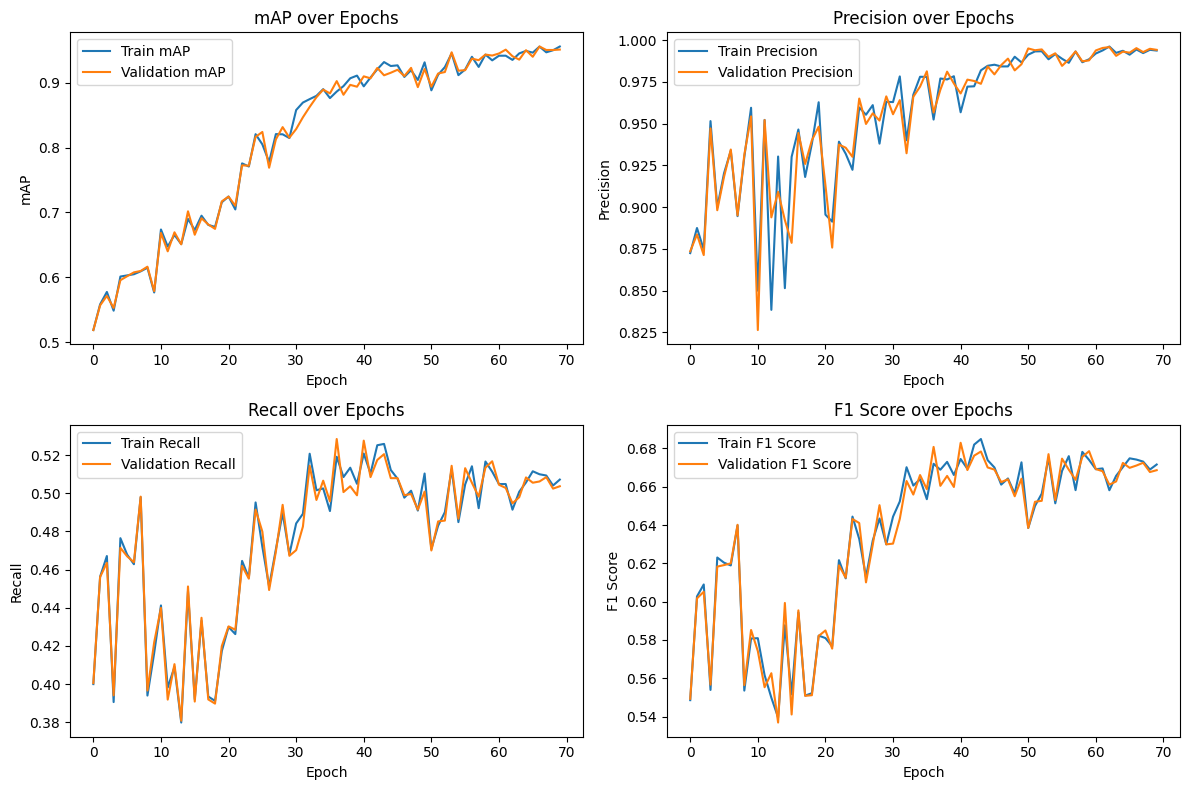

In [22]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os

# Define necessary functions
def iou(box1, box2):
    """Compute the IoU of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def calculate_precision_recall(all_boxes, all_scores, all_labels, true_boxes, true_labels, iou_threshold=0.5):
    """Calculate precision and recall for a given IoU threshold."""
    if len(all_scores) == 0:
        return np.array([]), np.array([]), np.array([])

    sorted_indices = np.argsort(-np.array(all_scores))
    all_boxes = np.array(all_boxes)[sorted_indices]
    all_labels = np.array(all_labels)[sorted_indices]
    all_scores = np.array(all_scores)[sorted_indices]

    num_true_boxes = len(true_boxes)
    num_pred_boxes = len(all_boxes)

    true_positive = np.zeros(num_pred_boxes)
    false_positive = np.zeros(num_pred_boxes)
    detected_boxes = []

    for idx, pred_box in enumerate(all_boxes):
        max_iou = 0
        max_idx = -1
        for jdx, true_box in enumerate(true_boxes):
            if all_labels[idx] == true_labels[jdx] and jdx not in detected_boxes:
                current_iou = iou(pred_box, true_box)
                if current_iou > max_iou:
                    max_iou = current_iou
                    max_idx = jdx

        if max_iou >= iou_threshold:
            true_positive[idx] = 1
            detected_boxes.append(max_idx)
        else:
            false_positive[idx] = 1

    cum_tp = np.cumsum(true_positive)
    cum_fp = np.cumsum(false_positive)
    precision = cum_tp / (cum_tp + cum_fp) if (cum_tp + cum_fp).sum() > 0 else np.array([])
    recall = cum_tp / num_true_boxes if num_true_boxes > 0 else np.array([])

    return precision, recall, all_scores

def calculate_ap(precision, recall):
    """Calculate the average precision for a single class."""
    if len(precision) == 0 or len(recall) == 0:
        return 0.0

    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))

    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])

    indices = np.where(recall[1:] != recall[:-1])[0]
    average_precision = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])

    return average_precision

def evaluate_model(loader, model, device, iou_thresh=0.5):
    model.eval()
    all_detections = []
    all_annotations = []

    with torch.no_grad():
        for images, targets in loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                boxes = output['boxes'].cpu().numpy()

                target_boxes = targets[i]['boxes'].cpu().numpy()
                target_labels = targets[i]['labels'].cpu().numpy()

                valid = scores > 0.5
                scores = scores[valid]
                labels = labels[valid]
                boxes = boxes[valid]

                all_detections.extend([(box, score, label) for box, score, label in zip(boxes, scores, labels)])
                all_annotations.extend([(box, label) for box, label in zip(target_boxes, target_labels)])

    if not all_detections:
        return [], [], [], 0

    pred_boxes, pred_scores, pred_labels = zip(*all_detections)
    true_boxes, true_labels = zip(*all_annotations)

    aps, precisions, recalls = [], [], []

    for class_id in range(1, 6):  # Loop through classes 1 to 6
        class_pred_boxes = [pred_boxes[i] for i in range(len(pred_labels)) if pred_labels[i] == class_id]
        class_pred_scores = [pred_scores[i] for i in range(len(pred_labels)) if pred_labels[i] == class_id]
        class_true_boxes = [true_boxes[i] for i in range(len(true_labels)) if true_labels[i] == class_id]

        precision, recall, _ = calculate_precision_recall(class_pred_boxes, class_pred_scores, [class_id]*len(class_pred_boxes), class_true_boxes, [class_id]*len(class_true_boxes), iou_threshold=iou_thresh)
        ap = calculate_ap(precision, recall)

        if len(precision) == 0:
            print(f"No predictions for class {class_id}.")
        if len(recall) == 0:
            print(f"No true positives for class {class_id}.")

        aps.append(ap)
        precisions.append(np.mean(precision) if len(precision) > 0 else float('nan'))
        recalls.append(np.mean(recall) if len(recall) > 0 else float('nan'))

    mean_ap = np.mean(aps)
    return precisions, recalls, aps, mean_ap

# Verify GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

model = model.to(device)

num_epochs = 70

# Initialize lists to store loss values
epoch_losses = []
epoch_losses_dict = []


# Start the timer for total training time
total_start_time = time.time()

# Initialize lists to store metrics for each epoch
train_mAPs, val_mAPs = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

for epoch in range(num_epochs):
    # Start the timer for the epoch
    epoch_start_time = time.time()

    losses, losses_dict = train_one_epoch(model, optimizer, train_loader, device, epoch)

    # Evaluate on training set
    train_precisions_epoch, train_recalls_epoch, train_aps, train_mean_ap = evaluate_model(train_loader, model, device)
    train_mAPs.append(train_mean_ap)
    train_precisions.append(np.nanmean(train_precisions_epoch))
    train_recalls.append(np.nanmean(train_recalls_epoch))
    print(f"Epoch {epoch} - Train mAP@0.50: {train_mean_ap}")
    for class_id, (precision, recall, ap) in enumerate(zip(train_precisions_epoch, train_recalls_epoch, train_aps), start=1):
        print(f"Class {class_id} - Precision: {precision}, Recall: {recall}, AP: {ap}")

    # Evaluate on validation set
    val_precisions_epoch, val_recalls_epoch, val_aps, val_mean_ap = evaluate_model(val_loader, model, device)
    val_mAPs.append(val_mean_ap)
    val_precisions.append(np.nanmean(val_precisions_epoch))
    val_recalls.append(np.nanmean(val_recalls_epoch))
    print(f"Epoch {epoch} - Validation mAP@0.50: {val_mean_ap}")
    for class_id, (precision, recall, ap) in enumerate(zip(val_precisions_epoch, val_recalls_epoch, val_aps), start=1):
        print(f"Class {class_id} - Precision: {precision}, Recall: {recall}, AP: {ap}")


    # Store the epoch loss values
    epoch_losses.append(np.mean(losses))
    epoch_losses_dict.append(losses_dict.mean())

    # End the timer for the epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_duration:.2f} seconds")

# End the timer for total training time
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Total training time: {total_duration:.2f} seconds")

# Plot the stored metrics
epochs = range(num_epochs)
plt.figure(figsize=(12, 8))

# Plot mAP
plt.subplot(2, 2, 1)
plt.plot(epochs, train_mAPs, label='Train mAP')
plt.plot(epochs, val_mAPs, label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP over Epochs')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, train_recalls, label='Train Recall')
plt.plot(epochs, val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()

# Plot F1 Score
train_f1_scores = [2 * (p * r) / (p + r) for p, r in zip(train_precisions, train_recalls)]
val_f1_scores = [2 * (p * r) / (p + r) for p, r in zip(val_precisions, val_recalls)]
plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


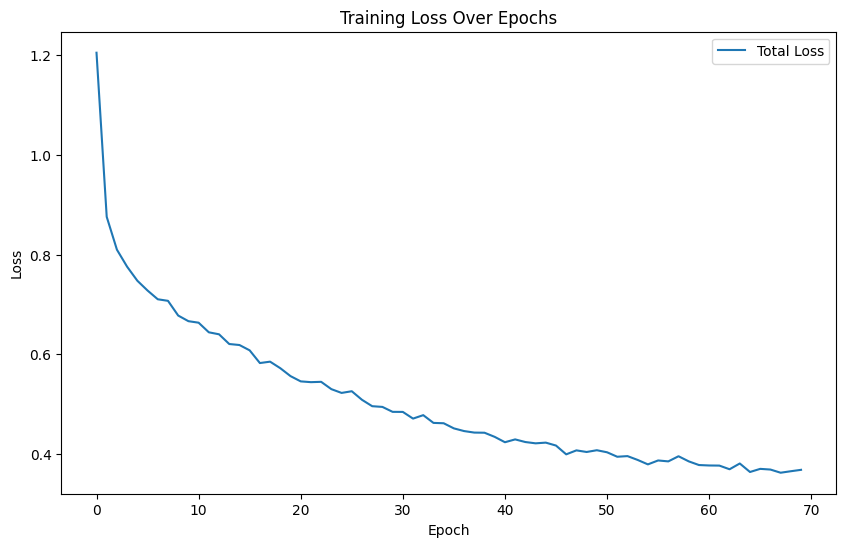

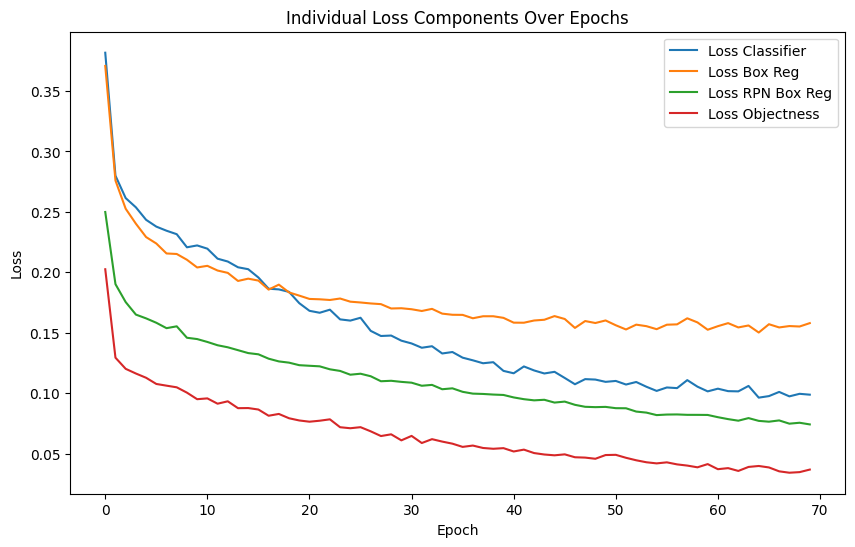

In [23]:
# Convert epoch_losses_dict to a DataFrame for easier plotting
epoch_losses_df = pd.DataFrame(epoch_losses_dict)

# Plot the overall loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_losses, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot the individual components of the loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_losses_df['loss_classifier'], label='Loss Classifier')
plt.plot(range(num_epochs), epoch_losses_df['loss_box_reg'], label='Loss Box Reg')
plt.plot(range(num_epochs), epoch_losses_df['loss_rpn_box_reg'], label='Loss RPN Box Reg')
plt.plot(range(num_epochs), epoch_losses_df['loss_objectness'], label='Loss Objectness')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Individual Loss Components Over Epochs')
plt.legend()
plt.show()


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = UI_Element_Detection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
img, _ = test_dataset[45]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

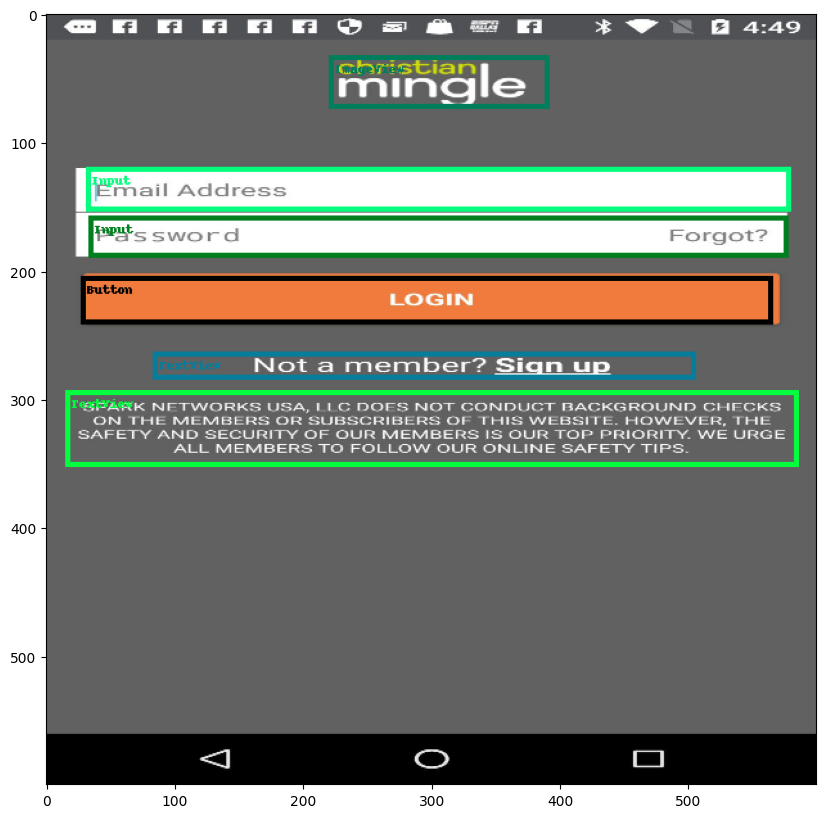

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4
).permute(1, 2, 0))

In [ ]:
pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

Detected text: Keep rtic logged ir
Detected text: Need Help ogging In?
Detected text: Skip Log In
Detected text: Create Account
Detected text: version 3.3-
Detected text: 


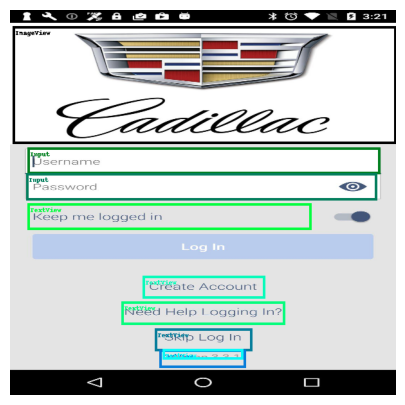

Detected text: nand
Detected text: User Namc
Detected text: Ocn wIth registered account
Detected text: signing UP; you agreeto the TermaofUse & Privacy Polick


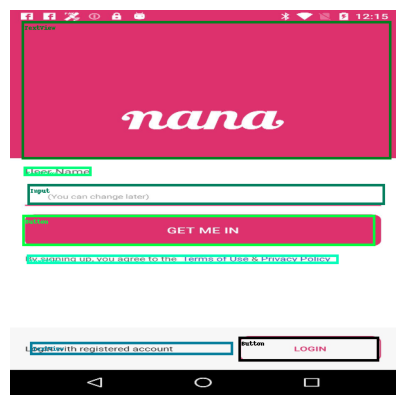

Detected text: PG
Detected text: Grace Chan
Detected text: 
Detected text: Aclc chilc's
Detected text: San Francisco


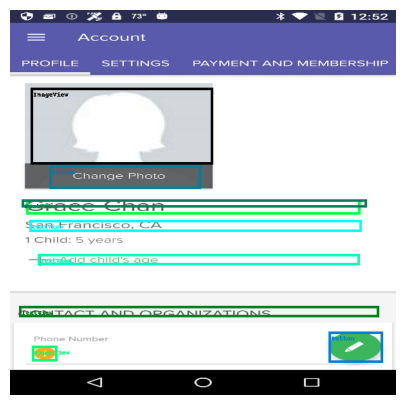

Detected text: Logout
Detected text: Phone
Detected text: ccount Linking


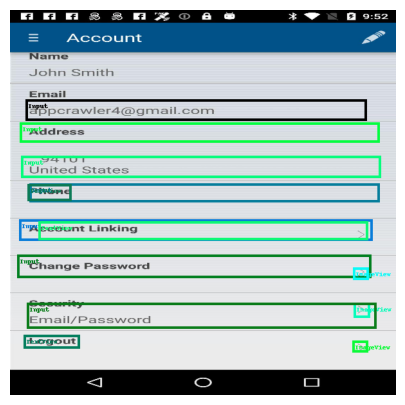

Detected text: V688se Try out MP3 Converter and convert your Jideos to mp3
Detected text: Add recipients
Detected text: appcrawlers@gmail-com
Detected text: Suagestions from Google


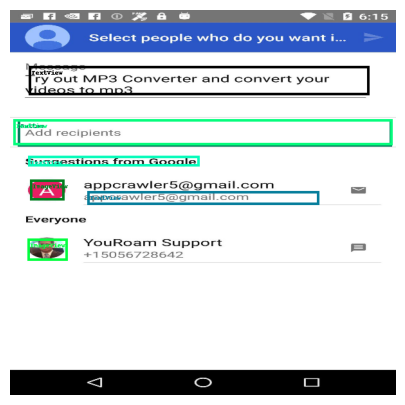

Detected text: Game Sid Story; Otogi Spirit Agents; Divine Girls (RIP Fantasy Warlord, best game ever)
Detected text: Socialising here then im lonely at my work on the roads Scandinavia 0n
Detected text: Likes Classic cars Snowmobil_ Fishing; Beer; Bowling; Wintersports_ Sex at public places, Ecchi anime & real life
Detected text: Wish the world was more like an Ecchi anime but
Detected text: skip the nosebleed thanks


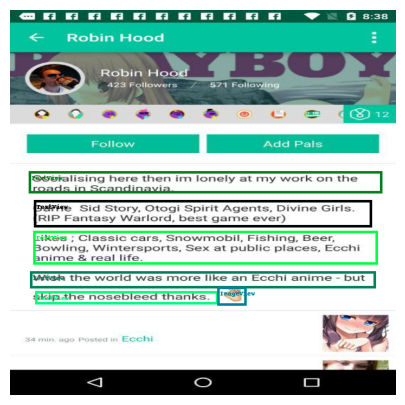

Detected text: Estadio Santiago Bernabeu Avenida de Concha Espina 1, Chamantin; Madrid
Detected text: 
Detected text: Officia Cha
Detected text: Team Profle
Detected text: 
Detected text: Videos
Detected text: 
Detected text: Games
Detected text: 
Detected text: grass
Detected text: Rank
Detected text: T Kroos
Detected text: Cristiano Ronaldo
Detected text: Tview Jersey Squad Stats Transters Games
Detected text: 
Detected text: 
Detected text: 1902
Detected text: Overview
Detected text: Official Channels


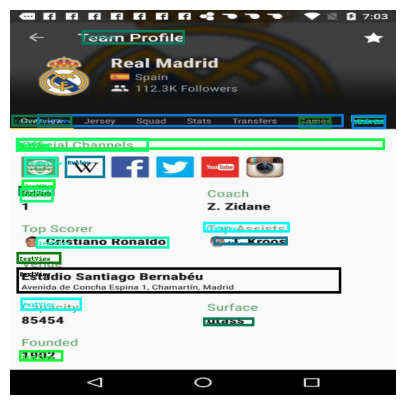

Detected text: Mobile +14153402255


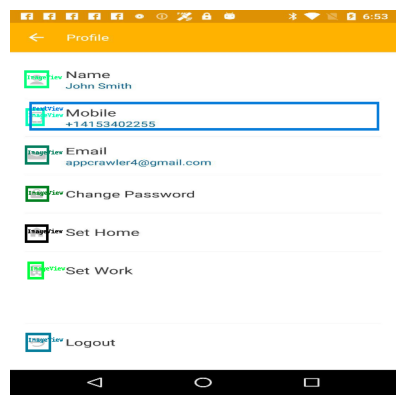

Detected text: sian in with
Detected text: Sign In
Detected text: Sian LD
Detected text: 
Detected text: Eoraot Passutoro


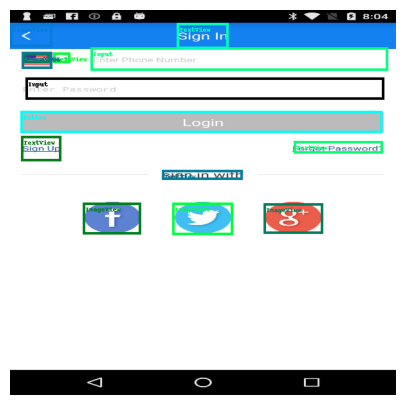

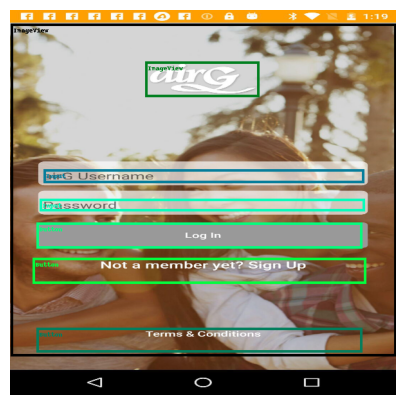

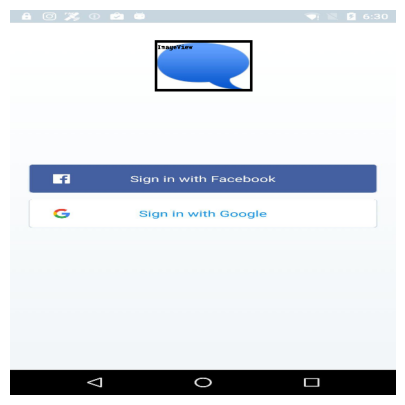

In [ ]:
import pandas as pd
from flask import Flask, request, jsonify

import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import numpy as np
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2
import easyocr
from IPython.display import display, HTML
import ipywidgets as widgets


# Load the expert dataset
expert_dataset_path = '/content/drive/My Drive/MASC_UI_dataset/MASC_UI/MASC_UI/expert_dataset.xlsx'
expert_df = pd.read_excel(expert_dataset_path)
login_texts = expert_df['Login'].dropna().tolist()
home_texts = expert_df['Home'].dropna().tolist()
welcome_texts = expert_df['Welcome'].dropna().tolist()
profile_texts = expert_df['Profile'].dropna().tolist()

reader = easyocr.Reader(['en'])  # Initialize EasyOCR with English language support

# Function to load an image from file picker
def load_image(uploaded):
    image = Image.open(io.BytesIO(uploaded['content'])).convert("RGB")
    return image

# Function to preprocess the image without bbox parameters for inference
def preprocess_image_inference(image, transform):
    image = np.array(image)
    transformed = transform(image=image)
    image_tensor = transformed['image']
    return image_tensor.float() / 255.0  # Convert to float32 and normalize

# Function to recognize text
def recognize_text(image, predictions, classes):
    recognized_texts = []
    boxes = predictions['boxes'][predictions['scores'] > 0.5].cpu().numpy()
    labels = predictions['labels'][predictions['scores'] > 0.5].cpu().numpy()

    for box, label in zip(boxes, labels):
        class_name = classes[label]
        if class_name == 'TextView':
            x_min, y_min, x_max, y_max = map(int, box)
            cropped_image = image[y_min:y_max, x_min:x_max]
            results = reader.readtext(cropped_image)
            text_lines = " ".join([result[1] for result in results])  # Join words into a line of text
            recognized_texts.append((text_lines, box, class_name))
            print("Detected text:", text_lines)  # Print only the text line
    return recognized_texts

# Function to visualize results
def visualize_results(image_tensor, predictions, classes):
    img_np = (image_tensor * 255).to(torch.uint8).cpu().permute(1, 2, 0).numpy()  # Convert to numpy for visualization
    recognized_texts = recognize_text(img_np, predictions, classes)

    fig = plt.figure(figsize=(7, 5))
    plt.imshow(draw_bounding_boxes(
        (image_tensor * 255).to(torch.uint8).cpu(),
        predictions['boxes'][predictions['scores'] > 0.5].cpu(),
        [classes[i] for i in predictions['labels'][predictions['scores'] > 0.5].tolist()],
        width=4).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    return recognized_texts

# Function to check UX and get suggestions
def check_ux_and_suggestions(detected_texts, labels):
    detected_words = set(" ".join([text for text, _, _ in detected_texts]).split())

    # Combine all expert dataset texts into a single set of words
    expert_words = set()
    for column_texts in [login_texts, home_texts, welcome_texts, profile_texts]:
        for text in column_texts:
            expert_words.update(text.split())

    # Check if any detected word matches any expert word
    if detected_words & expert_words:
        return "Good UX", None

    detected_labels = set(labels)

    # Check for Login screen
    if 'Input' in detected_labels and not any(word in detected_words for word in login_texts):
        return "Fault in UX - Login", login_texts

    # Check for Home screen
    if detected_labels == {'ImageView', 'TextView', 'Button'}:
        return "Fault in UX - Home", home_texts

    # Check for Welcome screen
    if detected_labels <= {'ImageView', 'Button'} and len(detected_labels) == 2:
        return "Fault in UX - Welcome", welcome_texts

    # Check for Profile screen
    if not any(word in detected_words for word in profile_texts):
        return "Fault in UX - Home", home_texts

    # If none of the above, return Good UX
    return "Good UX", None

# Function to load and predict
def load_and_predict(change):
    uploaded = list(file_picker.value.values())[0]
    if not uploaded:
        return

    new_image = load_image(uploaded)
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ])
    image_tensor = preprocess_image_inference(new_image, transform)

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model([image_tensor])
        pred = predictions[0]

    recognized_texts = visualize_results(image_tensor, pred, classes)
    detected_labels = [classes[label] for label in pred['labels'][pred['scores'] > 0.5].cpu().numpy()]
    ux_result, suggestions = check_ux_and_suggestions(recognized_texts, detected_labels)
    if ux_result != "Good UX" and suggestions:
        result_html.value = f"{ux_result}<br><br>Suggestions:<br>" + "<br>".join(suggestions)
    else:
        result_html.value = ux_result

# Create widgets
file_picker = widgets.FileUpload(accept='image/*', multiple=False, description="Upload Image", button_style='info')
file_picker.observe(load_and_predict, names='value')

result_html = widgets.HTML(value="", layout=widgets.Layout(width='100%', height='200px', border='solid 1px black', padding='10px'))

# Display widgets with layout
image_output = widgets.Output(layout=widgets.Layout(width='50%'))
result_output = widgets.VBox([
    widgets.HTML("<h2>UI Element Detection</h2>"),
    file_picker,
    widgets.HTML("<h3>UX Evaluation Result:</h3>"),
    result_html
], layout=widgets.Layout(align_items='center', width='50%', margin='0 auto'))

# Function to load and predict, and update the image_output widget
def load_and_predict(change):
    uploaded = list(file_picker.value.values())[0]
    if not uploaded:
        return

    new_image = load_image(uploaded)
    transform = A.Compose([
        A.Resize(600, 600),
        ToTensorV2()
    ])
    image_tensor = preprocess_image_inference(new_image, transform)

    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model([image_tensor])
        pred = predictions[0]

    with image_output:
        image_output.clear_output()
        recognized_texts = visualize_results(image_tensor, pred, classes)

    detected_labels = [classes[label] for label in pred['labels'][pred['scores'] > 0.5].cpu().numpy()]
    ux_result, suggestions = check_ux_and_suggestions(recognized_texts, detected_labels)
    if ux_result != "Good UX" and suggestions:
        result_html.value = f"{ux_result}<br><br>Suggestions:<br>" + "<br>".join(suggestions)
    else:
        result_html.value = ux_result

# Display widgets with layout
file_picker.observe(load_and_predict, names='value')

app_layout = widgets.HBox([
    image_output,
    result_output
], layout=widgets.Layout(align_items='center', width='100%', margin='10 auto'))

display(app_layout)
